In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

In [3]:
def sales_sum(row):
    #print(row)
    return sum(v for i, v in row.items() if 'Sales' in i) 

df_train_Y['Sales'] = df_train_Y.apply(lambda x: sales_sum(x), axis=1)
df_train_Y.head()

,SalesRent,SalesRyutsu,SalesSck,SalesMansionBkn,SalesMansionKen,SalesKodateBkn,SalesKodateKen,Impressions,Clicks,Cost,Sales
2018-02-23,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2011,12,137.569992,0.000000
2018-02-24,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1660,12,135.479992,0.000000
2018-02-25,0.0,0.0,26.378694,0.0,0.0,0.0,0.0,1576,16,180.639992,26.378694
2018-02-26,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1518,19,214.509981,0.000000
2018-02-27,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1980,12,137.739990,0.000000


In [4]:
df_val_Y['Sales'] = df_val_Y.apply(lambda x: sales_sum(x), axis=1)
df_val_Y.head()

,SalesRent,SalesRyutsu,SalesSck,SalesMansionBkn,SalesMansionKen,SalesKodateBkn,SalesKodateKen,Impressions,Clicks,Cost,Sales
2019-11-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32092,224,5885.0,0.0
2019-11-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36651,291,8730.0,0.0
2019-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35327,246,7380.0,0.0
2019-11-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41620,225,6750.0,0.0
2019-11-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38849,245,7350.0,0.0


### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

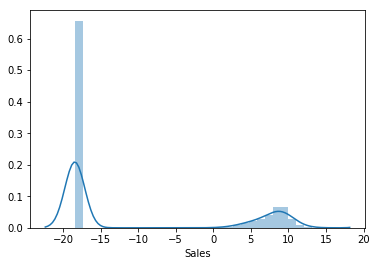

In [5]:
sns.distplot(np.log(df_train_Y['Sales'] + 0.00000001))
plt.plot()

In [6]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Sales']:
    df_train_Y['Sales_log'] = df_train_Y['Sales'].apply(log)
    df_val_Y['Sales_log'] = df_val_Y['Sales'].apply(log)

### データ構造転換

In [7]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Sales_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Sales_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [8]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=1000, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['Sales'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 0.0029585165792601754, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.0021343730579345514, 'lambda': 0.0008567419074188006, 'learning_rate': 0.42500000000000004, 'max_depth': 9, 'min_child_weight': 0.29886395399414345, 'n_estimators': 895.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:11.0656	eval-rmse:11.0714                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.5143	eval-rmse:9.39405                                                                                

[2]	train-rmse:7.39003	eval-rmse:8.81333                                                      

Stopping. Best iteration:                                                                                              
[8]	train-rmse:7.29809	eval-rmse:8.41756


loss: 4.8457167605167904e+17                                                                                           
Training with params:                                                                                                  
{'alpha': 0.0007041390259684471, 'colsample_bytree': 0.75, 'gamma': 0.0021108260672005356, 'lambda': 1.184699784296092, 'learning_rate': 0.325, 'max_depth': 4, 'min_child_weight': 3.383903371183094, 'n_estimators': 194.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:12.45	eval-rmse:11.9573                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                 

[13]	train-rmse:7.26197	eval-rmse:8.44308                                                                              

[14]	train-rmse:7.24964	eval-rmse:8.43516                                                                              

[15]	train-rmse:7.24498	eval-rmse:8.42985                                                                              

[16]	train-rmse:7.23527	eval-rmse:8.43285                                                                              

[17]	train-rmse:7.22387	eval-rmse:8.43454                                                                              

[18]	train-rmse:7.21771	eval-rmse:8.43961                                                                              

[19]	train-rmse:7.21312	eval-rmse:8.44645                                                                              

[20]	train-rmse:7.20837	eval-rmse:8.44626                                                                              

[21]	train-rmse:7.20303	eval-rms

[37]	train-rmse:7.22187	eval-rmse:8.33575                                                                              

[38]	train-rmse:7.20992	eval-rmse:8.33037                                                                              

[39]	train-rmse:7.19938	eval-rmse:8.32733                                                                              

[40]	train-rmse:7.18841	eval-rmse:8.31832                                                                              

[41]	train-rmse:7.17982	eval-rmse:8.31622                                                                              

[42]	train-rmse:7.17011	eval-rmse:8.31056                                                                              

[43]	train-rmse:7.16241	eval-rmse:8.30717                                                                              

[44]	train-rmse:7.15402	eval-rmse:8.30347                                                                              

[45]	train-rmse:7.1477	eval-rmse

[7]	train-rmse:8.624	eval-rmse:9.37569                                                                                 

[8]	train-rmse:8.24217	eval-rmse:9.13526                                                                               

[9]	train-rmse:7.92727	eval-rmse:8.94737                                                                               

[10]	train-rmse:7.67146	eval-rmse:8.80199                                                                              

[11]	train-rmse:7.45904	eval-rmse:8.68922                                                                              

[12]	train-rmse:7.28761	eval-rmse:8.60402                                                                              

[13]	train-rmse:7.1464	eval-rmse:8.54154                                                                               

[14]	train-rmse:7.03047	eval-rmse:8.49646                                                                              

[15]	train-rmse:6.93408	eval-rms

[74]	train-rmse:6.01186	eval-rmse:8.32551                                                                              

[75]	train-rmse:5.99996	eval-rmse:8.32658                                                                              

[76]	train-rmse:5.99038	eval-rmse:8.32729                                                                              

[77]	train-rmse:5.98701	eval-rmse:8.32812                                                                              

[78]	train-rmse:5.98081	eval-rmse:8.32808                                                                              

[79]	train-rmse:5.97479	eval-rmse:8.32878                                                                              

[80]	train-rmse:5.96453	eval-rmse:8.32688                                                                              

Stopping. Best iteration:                                                                                              
[60]	train-rmse:6.09197	eval-rmse

[53]	train-rmse:7.24795	eval-rmse:8.33024                                                                              

[54]	train-rmse:7.239	eval-rmse:8.32707                                                                                

[55]	train-rmse:7.22999	eval-rmse:8.3227                                                                               

[56]	train-rmse:7.22159	eval-rmse:8.31832                                                                              

[57]	train-rmse:7.21327	eval-rmse:8.31578                                                                              

[58]	train-rmse:7.20569	eval-rmse:8.31162                                                                              

[59]	train-rmse:7.19884	eval-rmse:8.30798                                                                              

[60]	train-rmse:7.19143	eval-rmse:8.30448                                                                              

[61]	train-rmse:7.18362	eval-rms

[14]	train-rmse:7.13796	eval-rmse:8.38361                                                                              

[15]	train-rmse:7.12255	eval-rmse:8.3774                                                                               

[16]	train-rmse:7.11256	eval-rmse:8.38413                                                                              

[17]	train-rmse:7.1054	eval-rmse:8.38471                                                                               

[18]	train-rmse:7.09665	eval-rmse:8.38462                                                                              

[19]	train-rmse:7.08671	eval-rmse:8.39176                                                                              

[20]	train-rmse:7.08231	eval-rmse:8.40274                                                                              

[21]	train-rmse:7.06933	eval-rmse:8.40781                                                                              

[22]	train-rmse:7.06617	eval-rms

[46]	train-rmse:7.26602	eval-rmse:8.37873                                                                              

[47]	train-rmse:7.26332	eval-rmse:8.37805                                                                              

[48]	train-rmse:7.26149	eval-rmse:8.37908                                                                              

[49]	train-rmse:7.26011	eval-rmse:8.37789                                                                              

[50]	train-rmse:7.25863	eval-rmse:8.37944                                                                              

[51]	train-rmse:7.25746	eval-rmse:8.38056                                                                              

[52]	train-rmse:7.25631	eval-rmse:8.37965                                                                              

[53]	train-rmse:7.25428	eval-rmse:8.38064                                                                              

[54]	train-rmse:7.25186	eval-rms

[7]	train-rmse:6.99525	eval-rmse:8.33449                                                                               

[8]	train-rmse:6.92834	eval-rmse:8.32266                                                                               

[9]	train-rmse:6.87792	eval-rmse:8.31883                                                                               

[10]	train-rmse:6.83882	eval-rmse:8.30339                                                                              

[11]	train-rmse:6.81247	eval-rmse:8.30072                                                                              

[12]	train-rmse:6.7847	eval-rmse:8.31929                                                                               

[13]	train-rmse:6.75543	eval-rmse:8.32033                                                                              

[14]	train-rmse:6.74007	eval-rmse:8.32409                                                                              

[15]	train-rmse:6.70709	eval-rms

[1]	train-rmse:12.8344	eval-rmse:12.2845                                                                               

[2]	train-rmse:11.5605	eval-rmse:11.3248                                                                               

[3]	train-rmse:10.5308	eval-rmse:10.5765                                                                               

[4]	train-rmse:9.71567	eval-rmse:10.0014                                                                               

[5]	train-rmse:9.07069	eval-rmse:9.56307                                                                               

[6]	train-rmse:8.56468	eval-rmse:9.23478                                                                               

[7]	train-rmse:8.17131	eval-rmse:8.98495                                                                               

[8]	train-rmse:7.86632	eval-rmse:8.80001                                                                               

[9]	train-rmse:7.62789	eval-rmse

[16]	train-rmse:7.37205	eval-rmse:8.49174                                                                              

[17]	train-rmse:7.36697	eval-rmse:8.4851                                                                               

[18]	train-rmse:7.36346	eval-rmse:8.48352                                                                              

[19]	train-rmse:7.35295	eval-rmse:8.48317                                                                              

[20]	train-rmse:7.33713	eval-rmse:8.46875                                                                              

[21]	train-rmse:7.33404	eval-rmse:8.47921                                                                              

[22]	train-rmse:7.32952	eval-rmse:8.47804                                                                              

[23]	train-rmse:7.32591	eval-rmse:8.46935                                                                              

[24]	train-rmse:7.32106	eval-rms

[16]	train-rmse:6.56006	eval-rmse:8.37944                                                                              

[17]	train-rmse:6.5382	eval-rmse:8.38698                                                                               

[18]	train-rmse:6.52456	eval-rmse:8.39823                                                                              

[19]	train-rmse:6.51447	eval-rmse:8.39595                                                                              

[20]	train-rmse:6.49758	eval-rmse:8.39964                                                                              

[21]	train-rmse:6.46898	eval-rmse:8.40319                                                                              

[22]	train-rmse:6.45128	eval-rmse:8.40215                                                                              

[23]	train-rmse:6.43199	eval-rmse:8.40696                                                                              

[24]	train-rmse:6.42218	eval-rms

[40]	train-rmse:7.01205	eval-rmse:8.32343                                                                              

[41]	train-rmse:7.00867	eval-rmse:8.32713                                                                              

[42]	train-rmse:7.00397	eval-rmse:8.33056                                                                              

[43]	train-rmse:6.99939	eval-rmse:8.32965                                                                              

[44]	train-rmse:6.99651	eval-rmse:8.32901                                                                              

[45]	train-rmse:6.98919	eval-rmse:8.32982                                                                              

[46]	train-rmse:6.98587	eval-rmse:8.33053                                                                              

[47]	train-rmse:6.98326	eval-rmse:8.33366                                                                              

[48]	train-rmse:6.98094	eval-rms

[9]	train-rmse:6.85335	eval-rmse:8.40258                                                                               

[10]	train-rmse:6.83726	eval-rmse:8.41241                                                                              

[11]	train-rmse:6.81881	eval-rmse:8.42769                                                                              

[12]	train-rmse:6.78688	eval-rmse:8.43889                                                                              

[13]	train-rmse:6.7739	eval-rmse:8.44578                                                                               

[14]	train-rmse:6.75595	eval-rmse:8.44267                                                                              

[15]	train-rmse:6.73736	eval-rmse:8.44738                                                                              

[16]	train-rmse:6.70645	eval-rmse:8.45676                                                                              

[17]	train-rmse:6.68915	eval-rms

[39]	train-rmse:7.27817	eval-rmse:8.41896                                                                              

[40]	train-rmse:7.27015	eval-rmse:8.40659                                                                              

[41]	train-rmse:7.26877	eval-rmse:8.40714                                                                              

[42]	train-rmse:7.26767	eval-rmse:8.40633                                                                              

[43]	train-rmse:7.26625	eval-rmse:8.40672                                                                              

[44]	train-rmse:7.26214	eval-rmse:8.40621                                                                              

[45]	train-rmse:7.25918	eval-rmse:8.41132                                                                              

[46]	train-rmse:7.25702	eval-rmse:8.41077                                                                              

[47]	train-rmse:7.25396	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.8687	eval-rmse:12.3044                                                                               

[2]	train-rmse:11.6095	eval-rmse:11.3536                                                                               

[3]	train-rmse:10.6016	eval-rmse:10.6119                                                                               

[4]	train-rmse:9.80132	eval-rmse:10.0281                                                                               

[5]	train-rmse:9.16776	eval-rmse:9.59647                                                                               

[6]	train-rmse:8.6759	eval-rmse:9.2773                                                                                 

[7]	train-rmse:8.29177	eval-rmse:9.02495                                                                               

[8]	train-rmse:8.00046	eval-rmse

[12]	train-rmse:12.8622	eval-rmse:12.293                                                                               

[13]	train-rmse:12.6511	eval-rmse:12.1321                                                                              

[14]	train-rmse:12.4483	eval-rmse:11.9771                                                                              

[15]	train-rmse:12.2507	eval-rmse:11.8251                                                                              

[16]	train-rmse:12.0591	eval-rmse:11.6809                                                                              

[17]	train-rmse:11.8738	eval-rmse:11.5401                                                                              

[18]	train-rmse:11.6956	eval-rmse:11.4061                                                                              

[19]	train-rmse:11.5238	eval-rmse:11.2768                                                                              

[20]	train-rmse:11.3587	eval-rms

[79]	train-rmse:7.5103	eval-rmse:8.48652                                                                               

[80]	train-rmse:7.49503	eval-rmse:8.47633                                                                              

[81]	train-rmse:7.48103	eval-rmse:8.46838                                                                              

[82]	train-rmse:7.46693	eval-rmse:8.46052                                                                              

[83]	train-rmse:7.45348	eval-rmse:8.45209                                                                              

[84]	train-rmse:7.44042	eval-rmse:8.44494                                                                              

[85]	train-rmse:7.42764	eval-rmse:8.43718                                                                              

[86]	train-rmse:7.41614	eval-rmse:8.43079                                                                              

[87]	train-rmse:7.40457	eval-rms

[40]	train-rmse:9.02405	eval-rmse:9.46758                                                                              

[41]	train-rmse:8.94757	eval-rmse:9.41626                                                                              

[42]	train-rmse:8.87376	eval-rmse:9.36572                                                                              

[43]	train-rmse:8.80316	eval-rmse:9.31686                                                                              

[44]	train-rmse:8.73452	eval-rmse:9.27193                                                                              

[45]	train-rmse:8.67005	eval-rmse:9.22908                                                                              

[46]	train-rmse:8.60755	eval-rmse:9.18729                                                                              

[47]	train-rmse:8.54778	eval-rmse:9.14859                                                                              

[48]	train-rmse:8.4901	eval-rmse

[1]	train-rmse:15.6853	eval-rmse:14.5119                                                                               

[2]	train-rmse:15.3866	eval-rmse:14.273                                                                                

[3]	train-rmse:15.0955	eval-rmse:14.0423                                                                               

[4]	train-rmse:14.8157	eval-rmse:13.8203                                                                               

[5]	train-rmse:14.5441	eval-rmse:13.6041                                                                               

[6]	train-rmse:14.2815	eval-rmse:13.3968                                                                               

[7]	train-rmse:14.0261	eval-rmse:13.1961                                                                               

[8]	train-rmse:13.7789	eval-rmse:13.0026                                                                               

[9]	train-rmse:13.5389	eval-rmse

[68]	train-rmse:7.72342	eval-rmse:8.61792                                                                              

[69]	train-rmse:7.70017	eval-rmse:8.60221                                                                              

[70]	train-rmse:7.67703	eval-rmse:8.58798                                                                              

[71]	train-rmse:7.65497	eval-rmse:8.57417                                                                              

[72]	train-rmse:7.63396	eval-rmse:8.56214                                                                              

[73]	train-rmse:7.61447	eval-rmse:8.5494                                                                               

[74]	train-rmse:7.59512	eval-rmse:8.53781                                                                              

[75]	train-rmse:7.57625	eval-rmse:8.52662                                                                              

[76]	train-rmse:7.55837	eval-rms

[29]	train-rmse:7.19444	eval-rmse:8.33532                                                                              

[30]	train-rmse:7.18085	eval-rmse:8.32938                                                                              

[31]	train-rmse:7.16721	eval-rmse:8.32048                                                                              

[32]	train-rmse:7.15545	eval-rmse:8.31429                                                                              

[33]	train-rmse:7.14509	eval-rmse:8.31115                                                                              

[34]	train-rmse:7.13722	eval-rmse:8.31157                                                                              

[35]	train-rmse:7.12781	eval-rmse:8.3079                                                                               

[36]	train-rmse:7.1214	eval-rmse:8.30943                                                                               

[37]	train-rmse:7.11447	eval-rms

[25]	train-rmse:8.19756	eval-rmse:8.94328                                                                              

[26]	train-rmse:8.10148	eval-rmse:8.88219                                                                              

[27]	train-rmse:8.01247	eval-rmse:8.82648                                                                              

[28]	train-rmse:7.93107	eval-rmse:8.77279                                                                              

[29]	train-rmse:7.85676	eval-rmse:8.72733                                                                              

[30]	train-rmse:7.78756	eval-rmse:8.68332                                                                              

[31]	train-rmse:7.72403	eval-rmse:8.64524                                                                              

[32]	train-rmse:7.66651	eval-rmse:8.61028                                                                              

[33]	train-rmse:7.61297	eval-rms

[92]	train-rmse:6.87563	eval-rmse:8.24015                                                                              

[93]	train-rmse:6.87153	eval-rmse:8.23949                                                                              

[94]	train-rmse:6.86953	eval-rmse:8.23966                                                                              

[95]	train-rmse:6.86669	eval-rmse:8.2386                                                                               

[96]	train-rmse:6.86265	eval-rmse:8.23866                                                                              

[97]	train-rmse:6.85944	eval-rmse:8.23777                                                                              

[98]	train-rmse:6.85633	eval-rmse:8.23751                                                                              

[99]	train-rmse:6.85318	eval-rmse:8.238                                                                                

loss: 102556436.3796284         

[53]	train-rmse:8.23624	eval-rmse:8.95155                                                                              

[54]	train-rmse:8.19166	eval-rmse:8.92345                                                                              

[55]	train-rmse:8.1486	eval-rmse:8.89564                                                                               

[56]	train-rmse:8.10626	eval-rmse:8.86794                                                                              

[57]	train-rmse:8.06654	eval-rmse:8.84068                                                                              

[58]	train-rmse:8.02852	eval-rmse:8.815                                                                                

[59]	train-rmse:7.99214	eval-rmse:8.79193                                                                              

[60]	train-rmse:7.9573	eval-rmse:8.76986                                                                               

[61]	train-rmse:7.9242	eval-rmse

[14]	train-rmse:7.19983	eval-rmse:8.32798                                                                              

[15]	train-rmse:7.17722	eval-rmse:8.31867                                                                              

[16]	train-rmse:7.15526	eval-rmse:8.30972                                                                              

[17]	train-rmse:7.14068	eval-rmse:8.30954                                                                              

[18]	train-rmse:7.12731	eval-rmse:8.30674                                                                              

[19]	train-rmse:7.11836	eval-rmse:8.30638                                                                              

[20]	train-rmse:7.10859	eval-rmse:8.30668                                                                              

[21]	train-rmse:7.09611	eval-rmse:8.31932                                                                              

[22]	train-rmse:7.08673	eval-rms

[33]	train-rmse:6.08851	eval-rmse:8.35658                                                                              

[34]	train-rmse:6.06952	eval-rmse:8.35378                                                                              

[35]	train-rmse:6.05504	eval-rmse:8.35209                                                                              

[36]	train-rmse:6.04047	eval-rmse:8.34874                                                                              

[37]	train-rmse:6.02541	eval-rmse:8.35023                                                                              

[38]	train-rmse:6.01213	eval-rmse:8.349                                                                                

[39]	train-rmse:5.99521	eval-rmse:8.35227                                                                              

[40]	train-rmse:5.97865	eval-rmse:8.35045                                                                              

[41]	train-rmse:5.96783	eval-rms

[17]	train-rmse:11.8756	eval-rmse:11.5414                                                                              

[18]	train-rmse:11.6987	eval-rmse:11.4078                                                                              

[19]	train-rmse:11.5249	eval-rmse:11.279                                                                               

[20]	train-rmse:11.3591	eval-rmse:11.1553                                                                              

[21]	train-rmse:11.199	eval-rmse:11.0366                                                                               

[22]	train-rmse:11.0432	eval-rmse:10.92                                                                                

[23]	train-rmse:10.8927	eval-rmse:10.8091                                                                              

[24]	train-rmse:10.7475	eval-rmse:10.7017                                                                              

[25]	train-rmse:10.6078	eval-rms

[84]	train-rmse:7.44029	eval-rmse:8.45468                                                                              

[85]	train-rmse:7.42821	eval-rmse:8.44765                                                                              

[86]	train-rmse:7.41671	eval-rmse:8.44005                                                                              

[87]	train-rmse:7.40478	eval-rmse:8.43372                                                                              

[88]	train-rmse:7.39411	eval-rmse:8.42749                                                                              

[89]	train-rmse:7.38352	eval-rmse:8.42209                                                                              

[90]	train-rmse:7.37337	eval-rmse:8.41806                                                                              

[91]	train-rmse:7.36398	eval-rmse:8.41248                                                                              

[92]	train-rmse:7.3548	eval-rmse

[45]	train-rmse:6.98622	eval-rmse:8.28227                                                                              

[46]	train-rmse:6.97744	eval-rmse:8.27869                                                                              

[47]	train-rmse:6.96993	eval-rmse:8.27793                                                                              

[48]	train-rmse:6.96215	eval-rmse:8.27604                                                                              

[49]	train-rmse:6.95332	eval-rmse:8.27427                                                                              

[50]	train-rmse:6.94719	eval-rmse:8.27356                                                                              

[51]	train-rmse:6.94097	eval-rmse:8.27207                                                                              

[52]	train-rmse:6.93391	eval-rmse:8.27035                                                                              

[53]	train-rmse:6.93005	eval-rms

[6]	train-rmse:8.27096	eval-rmse:9.26777                                                                               

[7]	train-rmse:7.83635	eval-rmse:9.02557                                                                               

[8]	train-rmse:7.49259	eval-rmse:8.8467                                                                                

[9]	train-rmse:7.22033	eval-rmse:8.72262                                                                               

[10]	train-rmse:7.01112	eval-rmse:8.63069                                                                              

[11]	train-rmse:6.83549	eval-rmse:8.5537                                                                               

[12]	train-rmse:6.69632	eval-rmse:8.5005                                                                               

[13]	train-rmse:6.58197	eval-rmse:8.47023                                                                              

[14]	train-rmse:6.49253	eval-rms

[17]	train-rmse:7.24968	eval-rmse:8.31756                                                                              

[18]	train-rmse:7.24211	eval-rmse:8.31905                                                                              

[19]	train-rmse:7.23439	eval-rmse:8.31658                                                                              

[20]	train-rmse:7.22863	eval-rmse:8.31581                                                                              

[21]	train-rmse:7.21997	eval-rmse:8.31774                                                                              

[22]	train-rmse:7.21356	eval-rmse:8.31729                                                                              

[23]	train-rmse:7.20899	eval-rmse:8.31277                                                                              

[24]	train-rmse:7.20275	eval-rmse:8.31051                                                                              

[25]	train-rmse:7.19869	eval-rms

[31]	train-rmse:7.31628	eval-rmse:8.37805                                                                              

[32]	train-rmse:7.29373	eval-rmse:8.36513                                                                              

[33]	train-rmse:7.27491	eval-rmse:8.35624                                                                              

[34]	train-rmse:7.25753	eval-rmse:8.35227                                                                              

[35]	train-rmse:7.24305	eval-rmse:8.34417                                                                              

[36]	train-rmse:7.22853	eval-rmse:8.33783                                                                              

[37]	train-rmse:7.2149	eval-rmse:8.33107                                                                               

[38]	train-rmse:7.20394	eval-rmse:8.32509                                                                              

[39]	train-rmse:7.1937	eval-rmse

[0]	train-rmse:14.7694	eval-rmse:13.7826                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.4589	eval-rmse:12.7485                                                                               

[2]	train-rmse:12.3543	eval-rmse:11.8802                                                                               

[3]	train-rmse:11.4261	eval-rmse:11.1852                                                                               

[4]	train-rmse:10.6524	eval-rmse:10.6162                                                                               

[5]	train-rmse:10.0125	eval-rmse:10.156                                                                                

[6]	train-rmse:9.48523	eval-rms

[65]	train-rmse:7.12683	eval-rmse:8.30985                                                                              

[66]	train-rmse:7.12455	eval-rmse:8.30849                                                                              

[67]	train-rmse:7.12301	eval-rmse:8.31189                                                                              

[68]	train-rmse:7.1202	eval-rmse:8.31201                                                                               

[69]	train-rmse:7.11761	eval-rmse:8.30988                                                                              

[70]	train-rmse:7.1157	eval-rmse:8.30926                                                                               

[71]	train-rmse:7.11486	eval-rmse:8.30971                                                                              

[72]	train-rmse:7.11381	eval-rmse:8.31132                                                                              

[73]	train-rmse:7.11071	eval-rms

[38]	train-rmse:7.53045	eval-rmse:8.50801                                                                              

[39]	train-rmse:7.49934	eval-rmse:8.48834                                                                              

[40]	train-rmse:7.47071	eval-rmse:8.47124                                                                              

[41]	train-rmse:7.44405	eval-rmse:8.45627                                                                              

[42]	train-rmse:7.41995	eval-rmse:8.44315                                                                              

[43]	train-rmse:7.39761	eval-rmse:8.43124                                                                              

[44]	train-rmse:7.37695	eval-rmse:8.41813                                                                              

[45]	train-rmse:7.35783	eval-rmse:8.40739                                                                              

[46]	train-rmse:7.34061	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.4183	eval-rmse:11.9587                                                                               

[2]	train-rmse:11.0917	eval-rmse:10.9621                                                                               

[3]	train-rmse:10.0705	eval-rmse:10.2101                                                                               

[4]	train-rmse:9.29777	eval-rmse:9.67707                                                                               

[5]	train-rmse:8.72022	eval-rmse:9.27425                                                                               

[6]	train-rmse:8.29769	eval-rmse:8.99087                                                                               

[7]	train-rmse:7.98946	eval-rms

[10]	train-rmse:8.33643	eval-rmse:9.18085                                                                              

[11]	train-rmse:8.06747	eval-rmse:9.01949                                                                              

[12]	train-rmse:7.83587	eval-rmse:8.87863                                                                              

[13]	train-rmse:7.63942	eval-rmse:8.77026                                                                              

[14]	train-rmse:7.47399	eval-rmse:8.68031                                                                              

[15]	train-rmse:7.33024	eval-rmse:8.60864                                                                              

[16]	train-rmse:7.20866	eval-rmse:8.54908                                                                              

[17]	train-rmse:7.10138	eval-rmse:8.50363                                                                              

[18]	train-rmse:7.00835	eval-rms

[0]	train-rmse:12.7205	eval-rmse:12.2006                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.4509	eval-rmse:10.5092                                                                               

[2]	train-rmse:9.08523	eval-rmse:9.53396                                                                               

[3]	train-rmse:8.30264	eval-rmse:9.00432                                                                               

[4]	train-rmse:7.86237	eval-rmse:8.71206                                                                               

[5]	train-rmse:7.62592	eval-rmse:8.55791                                                                               

[6]	train-rmse:7.49209	eval-rms

[17]	train-rmse:7.59594	eval-rmse:8.55956                                                                              

[18]	train-rmse:7.55359	eval-rmse:8.52838                                                                              

[19]	train-rmse:7.51978	eval-rmse:8.50391                                                                              

[20]	train-rmse:7.49252	eval-rmse:8.48603                                                                              

[21]	train-rmse:7.46881	eval-rmse:8.46953                                                                              

[22]	train-rmse:7.44951	eval-rmse:8.46378                                                                              

[23]	train-rmse:7.43428	eval-rmse:8.4535                                                                               

[24]	train-rmse:7.4179	eval-rmse:8.44143                                                                               

[25]	train-rmse:7.40579	eval-rms

[84]	train-rmse:7.238	eval-rmse:8.36834                                                                                

[85]	train-rmse:7.23659	eval-rmse:8.36833                                                                              

[86]	train-rmse:7.23609	eval-rmse:8.36913                                                                              

[87]	train-rmse:7.23507	eval-rmse:8.36945                                                                              

[88]	train-rmse:7.2344	eval-rmse:8.36972                                                                               

[89]	train-rmse:7.2322	eval-rmse:8.36975                                                                               

[90]	train-rmse:7.23162	eval-rmse:8.36999                                                                              

[91]	train-rmse:7.23108	eval-rmse:8.36979                                                                              

[92]	train-rmse:7.22989	eval-rms

[45]	train-rmse:7.14786	eval-rmse:8.30349                                                                              

[46]	train-rmse:7.14083	eval-rmse:8.3017                                                                               

[47]	train-rmse:7.13449	eval-rmse:8.2993                                                                               

[48]	train-rmse:7.12795	eval-rmse:8.29728                                                                              

[49]	train-rmse:7.12065	eval-rmse:8.2946                                                                               

[50]	train-rmse:7.11551	eval-rmse:8.29412                                                                              

[51]	train-rmse:7.11049	eval-rmse:8.29527                                                                              

[52]	train-rmse:7.10644	eval-rmse:8.29464                                                                              

[53]	train-rmse:7.10289	eval-rms

[6]	train-rmse:7.17302	eval-rmse:8.35229                                                                               

[7]	train-rmse:7.12208	eval-rmse:8.32927                                                                               

[8]	train-rmse:7.08717	eval-rmse:8.3305                                                                                

[9]	train-rmse:7.05049	eval-rmse:8.33145                                                                               

[10]	train-rmse:7.02412	eval-rmse:8.33347                                                                              

[11]	train-rmse:6.9999	eval-rmse:8.32731                                                                               

[12]	train-rmse:6.98298	eval-rmse:8.33419                                                                              

[13]	train-rmse:6.96835	eval-rmse:8.32975                                                                              

[14]	train-rmse:6.95355	eval-rms

Training with params:                                                                                                  
{'alpha': 9.194664098702147e-07, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0035024521347081735, 'lambda': 1.906222901352029e-06, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 0.3235040054580182, 'n_estimators': 174.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.6556	eval-rmse:14.5007                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.0428	eval-rmse:14.0204                                                                               

[2]	train-rmse:14.4651	eval-rmse:13.5722                                                                       

[62]	train-rmse:6.47368	eval-rmse:8.27765                                                                              

[63]	train-rmse:6.46336	eval-rmse:8.27661                                                                              

[64]	train-rmse:6.45297	eval-rmse:8.27145                                                                              

[65]	train-rmse:6.44429	eval-rmse:8.26947                                                                              

[66]	train-rmse:6.43554	eval-rmse:8.26722                                                                              

[67]	train-rmse:6.42341	eval-rmse:8.26199                                                                              

[68]	train-rmse:6.41581	eval-rmse:8.25995                                                                              

[69]	train-rmse:6.40742	eval-rmse:8.25973                                                                              

[70]	train-rmse:6.39701	eval-rms

[23]	train-rmse:6.23913	eval-rmse:8.85127                                                                              

Stopping. Best iteration:                                                                                              
[3]	train-rmse:6.9453	eval-rmse:8.54662


loss: 2.5340739775155277e+18                                                                                           
Training with params:                                                                                                  
{'alpha': 2.1547537502876353e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.0027212278084964912, 'lambda': 1.6584489379490202e-06, 'learning_rate': 0.17500000000000002, 'max_depth': 8, 'min_child_weight': 0.27948949039890786, 'n_estimators': 181.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.0767	eval-rmse:13.2503                                                                               

Multiple eval metrics have been passed: 'eval-rmse' wi

[12]	train-rmse:10.3357	eval-rmse:10.5098                                                                              

[13]	train-rmse:10.0563	eval-rmse:10.3131                                                                              

[14]	train-rmse:9.79581	eval-rmse:10.1323                                                                              

[15]	train-rmse:9.5529	eval-rmse:9.96641                                                                               

[16]	train-rmse:9.32659	eval-rmse:9.81362                                                                              

[17]	train-rmse:9.11582	eval-rmse:9.6736                                                                               

[18]	train-rmse:8.92191	eval-rmse:9.54563                                                                              

[19]	train-rmse:8.74088	eval-rmse:9.43369                                                                              

[20]	train-rmse:8.57245	eval-rms

[79]	train-rmse:6.35679	eval-rmse:8.25003                                                                              

[80]	train-rmse:6.35236	eval-rmse:8.24752                                                                              

[81]	train-rmse:6.34848	eval-rmse:8.24866                                                                              

[82]	train-rmse:6.34291	eval-rmse:8.24862                                                                              

[83]	train-rmse:6.33739	eval-rmse:8.24512                                                                              

[84]	train-rmse:6.33034	eval-rmse:8.24635                                                                              

[85]	train-rmse:6.32519	eval-rmse:8.24677                                                                              

[86]	train-rmse:6.31928	eval-rmse:8.24999                                                                              

[87]	train-rmse:6.31377	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.89208	eval-rmse:10.0975                                                                               

[2]	train-rmse:8.51796	eval-rmse:9.20106                                                                               

[3]	train-rmse:7.78459	eval-rmse:8.77593                                                                               

[4]	train-rmse:7.40104	eval-rmse:8.56833                                                                               

[5]	train-rmse:7.1959	eval-rmse:8.48287                                                                                

[6]	train-rmse:7.06958	eval-rmse:8.47171                                                                               

[7]	train-rmse:7.00004	eval-rms

[25]	train-rmse:6.48865	eval-rmse:8.30002                                                                              

[26]	train-rmse:6.47181	eval-rmse:8.30149                                                                              

[27]	train-rmse:6.46057	eval-rmse:8.30226                                                                              

[28]	train-rmse:6.44432	eval-rmse:8.30163                                                                              

[29]	train-rmse:6.43112	eval-rmse:8.30629                                                                              

[30]	train-rmse:6.42053	eval-rmse:8.305                                                                                

[31]	train-rmse:6.40709	eval-rmse:8.30454                                                                              

[32]	train-rmse:6.39901	eval-rmse:8.30329                                                                              

[33]	train-rmse:6.39045	eval-rms

[41]	train-rmse:7.31392	eval-rmse:8.33285                                                                              

[42]	train-rmse:7.31126	eval-rmse:8.3301                                                                               

[43]	train-rmse:7.30849	eval-rmse:8.33107                                                                              

[44]	train-rmse:7.30675	eval-rmse:8.33216                                                                              

[45]	train-rmse:7.30405	eval-rmse:8.33191                                                                              

[46]	train-rmse:7.30096	eval-rmse:8.32833                                                                              

[47]	train-rmse:7.29817	eval-rmse:8.32545                                                                              

[48]	train-rmse:7.29602	eval-rmse:8.32554                                                                              

[49]	train-rmse:7.29416	eval-rms

[2]	train-rmse:14.4662	eval-rmse:13.5652                                                                               

[3]	train-rmse:13.9251	eval-rmse:13.1477                                                                               

[4]	train-rmse:13.4154	eval-rmse:12.7581                                                                               

[5]	train-rmse:12.937	eval-rmse:12.3971                                                                                

[6]	train-rmse:12.4889	eval-rmse:12.0597                                                                               

[7]	train-rmse:12.0699	eval-rmse:11.7466                                                                               

[8]	train-rmse:11.6741	eval-rmse:11.4571                                                                               

[9]	train-rmse:11.3058	eval-rmse:11.1876                                                                               

[10]	train-rmse:10.9598	eval-rms

[69]	train-rmse:6.42408	eval-rmse:8.26456                                                                              

[70]	train-rmse:6.4152	eval-rmse:8.26469                                                                               

[71]	train-rmse:6.40768	eval-rmse:8.26334                                                                              

[72]	train-rmse:6.39905	eval-rmse:8.26304                                                                              

[73]	train-rmse:6.39284	eval-rmse:8.26158                                                                              

[74]	train-rmse:6.38752	eval-rmse:8.25946                                                                              

[75]	train-rmse:6.38048	eval-rmse:8.25706                                                                              

[76]	train-rmse:6.37435	eval-rmse:8.25505                                                                              

[77]	train-rmse:6.36756	eval-rms

[30]	train-rmse:6.55219	eval-rmse:8.47293                                                                              

[31]	train-rmse:6.54802	eval-rmse:8.47711                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:6.8646	eval-rmse:8.41471


loss: 3693491213829.16                                                                                                 
Training with params:                                                                                                  
{'alpha': 3.303119251864565e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.1871396001949653e-06, 'lambda': 0.0001632370059832733, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.4190392260579419, 'n_estimators': 702.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.0706	eval-rmse:14.0242                               

[58]	train-rmse:7.16998	eval-rmse:8.29304                                                                              

[59]	train-rmse:7.16707	eval-rmse:8.29068                                                                              

[60]	train-rmse:7.16542	eval-rmse:8.29202                                                                              

[61]	train-rmse:7.16414	eval-rmse:8.29225                                                                              

[62]	train-rmse:7.16089	eval-rmse:8.29291                                                                              

[63]	train-rmse:7.15799	eval-rmse:8.29231                                                                              

[64]	train-rmse:7.15666	eval-rmse:8.29293                                                                              

[65]	train-rmse:7.15509	eval-rmse:8.29388                                                                              

[66]	train-rmse:7.15286	eval-rms

[38]	train-rmse:7.24122	eval-rmse:8.48                                                                                 

[39]	train-rmse:7.23776	eval-rmse:8.48026                                                                              

[40]	train-rmse:7.23414	eval-rmse:8.47611                                                                              

[41]	train-rmse:7.23123	eval-rmse:8.47807                                                                              

[42]	train-rmse:7.22789	eval-rmse:8.47475                                                                              

[43]	train-rmse:7.22386	eval-rmse:8.47628                                                                              

[44]	train-rmse:7.21861	eval-rmse:8.47962                                                                              

[45]	train-rmse:7.21328	eval-rmse:8.48032                                                                              

[46]	train-rmse:7.20948	eval-rms

[10]	train-rmse:7.15398	eval-rmse:8.305                                                                                

[11]	train-rmse:7.1112	eval-rmse:8.29009                                                                               

[12]	train-rmse:7.07615	eval-rmse:8.28445                                                                              

[13]	train-rmse:7.0529	eval-rmse:8.27508                                                                               

[14]	train-rmse:7.02214	eval-rmse:8.2612                                                                               

[15]	train-rmse:6.9982	eval-rmse:8.26363                                                                               

[16]	train-rmse:6.97879	eval-rmse:8.261                                                                                

[17]	train-rmse:6.96252	eval-rmse:8.24568                                                                              

[18]	train-rmse:6.94897	eval-rms

[31]	train-rmse:6.39334	eval-rmse:8.36007                                                                              

[32]	train-rmse:6.35922	eval-rmse:8.35024                                                                              

[33]	train-rmse:6.32584	eval-rmse:8.33919                                                                              

[34]	train-rmse:6.29147	eval-rmse:8.33235                                                                              

[35]	train-rmse:6.26236	eval-rmse:8.32785                                                                              

[36]	train-rmse:6.23404	eval-rmse:8.3224                                                                               

[37]	train-rmse:6.20448	eval-rmse:8.31452                                                                              

[38]	train-rmse:6.18222	eval-rmse:8.31223                                                                              

[39]	train-rmse:6.16137	eval-rms

[14]	train-rmse:7.0592	eval-rmse:8.38462                                                                               

[15]	train-rmse:7.00512	eval-rmse:8.36515                                                                              

[16]	train-rmse:6.95927	eval-rmse:8.35318                                                                              

[17]	train-rmse:6.92528	eval-rmse:8.34062                                                                              

[18]	train-rmse:6.89321	eval-rmse:8.33705                                                                              

[19]	train-rmse:6.86498	eval-rmse:8.32851                                                                              

[20]	train-rmse:6.84222	eval-rmse:8.32474                                                                              

[21]	train-rmse:6.82301	eval-rmse:8.32198                                                                              

[22]	train-rmse:6.80489	eval-rms

[29]	train-rmse:6.22699	eval-rmse:8.39737                                                                              

[30]	train-rmse:6.22206	eval-rmse:8.39985                                                                              

[31]	train-rmse:6.21096	eval-rmse:8.40127                                                                              

[32]	train-rmse:6.192	eval-rmse:8.40498                                                                                

[33]	train-rmse:6.18666	eval-rmse:8.4073                                                                               

[34]	train-rmse:6.1783	eval-rmse:8.40912                                                                               

Stopping. Best iteration:                                                                                              
[14]	train-rmse:6.55256	eval-rmse:8.35381


loss: 213152967.15437973                                                                                      

[54]	train-rmse:8.30755	eval-rmse:8.97579                                                                              

[55]	train-rmse:8.26508	eval-rmse:8.94828                                                                              

[56]	train-rmse:8.22385	eval-rmse:8.91985                                                                              

[57]	train-rmse:8.184	eval-rmse:8.89312                                                                                

[58]	train-rmse:8.14656	eval-rmse:8.86838                                                                              

[59]	train-rmse:8.11022	eval-rmse:8.84469                                                                              

[60]	train-rmse:8.07551	eval-rmse:8.8223                                                                               

[61]	train-rmse:8.0423	eval-rmse:8.79952                                                                               

[62]	train-rmse:8.01023	eval-rms

[15]	train-rmse:7.11106	eval-rmse:8.37514                                                                              

[16]	train-rmse:7.09995	eval-rmse:8.37546                                                                              

[17]	train-rmse:7.0931	eval-rmse:8.38145                                                                               

[18]	train-rmse:7.08668	eval-rmse:8.3893                                                                               

[19]	train-rmse:7.0766	eval-rmse:8.39843                                                                               

[20]	train-rmse:7.06456	eval-rmse:8.39855                                                                              

[21]	train-rmse:7.05223	eval-rmse:8.39463                                                                              

[22]	train-rmse:7.04181	eval-rmse:8.3992                                                                               

[23]	train-rmse:7.03613	eval-rms

[44]	train-rmse:6.89792	eval-rmse:8.29056                                                                              

[45]	train-rmse:6.89247	eval-rmse:8.29237                                                                              

[46]	train-rmse:6.88746	eval-rmse:8.29196                                                                              

[47]	train-rmse:6.88098	eval-rmse:8.29465                                                                              

[48]	train-rmse:6.87256	eval-rmse:8.29306                                                                              

[49]	train-rmse:6.86946	eval-rmse:8.29334                                                                              

[50]	train-rmse:6.86522	eval-rmse:8.29258                                                                              

[51]	train-rmse:6.86128	eval-rmse:8.2914                                                                               

[52]	train-rmse:6.85689	eval-rms

[47]	train-rmse:7.29805	eval-rmse:8.34351                                                                              

[48]	train-rmse:7.29544	eval-rmse:8.34438                                                                              

[49]	train-rmse:7.29363	eval-rmse:8.34278                                                                              

[50]	train-rmse:7.29085	eval-rmse:8.34232                                                                              

[51]	train-rmse:7.28836	eval-rmse:8.3397                                                                               

[52]	train-rmse:7.28672	eval-rmse:8.34014                                                                              

[53]	train-rmse:7.28467	eval-rmse:8.34193                                                                              

[54]	train-rmse:7.28254	eval-rmse:8.34364                                                                              

[55]	train-rmse:7.28002	eval-rms

[8]	train-rmse:11.6026	eval-rmse:11.4562                                                                               

[9]	train-rmse:11.2231	eval-rmse:11.1883                                                                               

[10]	train-rmse:10.8713	eval-rmse:10.9441                                                                              

[11]	train-rmse:10.5426	eval-rmse:10.7166                                                                              

[12]	train-rmse:10.2315	eval-rmse:10.5066                                                                              

[13]	train-rmse:9.94488	eval-rmse:10.3105                                                                              

[14]	train-rmse:9.67539	eval-rmse:10.1291                                                                              

[15]	train-rmse:9.42404	eval-rmse:9.9636                                                                               

[16]	train-rmse:9.18763	eval-rms

[75]	train-rmse:5.97977	eval-rmse:8.28314                                                                              

[76]	train-rmse:5.96801	eval-rmse:8.28337                                                                              

[77]	train-rmse:5.95881	eval-rmse:8.28224                                                                              

[78]	train-rmse:5.95153	eval-rmse:8.28072                                                                              

[79]	train-rmse:5.94278	eval-rmse:8.27851                                                                              

[80]	train-rmse:5.93815	eval-rmse:8.27566                                                                              

[81]	train-rmse:5.93291	eval-rmse:8.27626                                                                              

[82]	train-rmse:5.92601	eval-rmse:8.2748                                                                               

[83]	train-rmse:5.916	eval-rmse:

[36]	train-rmse:6.98405	eval-rmse:8.33712                                                                              

[37]	train-rmse:6.9789	eval-rmse:8.33775                                                                               

Stopping. Best iteration:                                                                                              
[17]	train-rmse:7.11635	eval-rmse:8.29752


loss: 1676100218.2081575                                                                                               
Training with params:                                                                                                  
{'alpha': 2.324802398257802e-08, 'colsample_bytree': 0.9500000000000001, 'gamma': 2.660539934482207e-06, 'lambda': 4.816911597422444e-06, 'learning_rate': 0.025, 'max_depth': 5, 'min_child_weight': 1.3638899420347588, 'n_estimators': 519.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.9913	eval-rmse:14.7574              

[57]	train-rmse:8.06515	eval-rmse:8.83368                                                                              

[58]	train-rmse:8.02704	eval-rmse:8.80929                                                                              

[59]	train-rmse:7.99096	eval-rmse:8.78647                                                                              

[60]	train-rmse:7.95598	eval-rmse:8.76419                                                                              

[61]	train-rmse:7.92249	eval-rmse:8.74331                                                                              

[62]	train-rmse:7.89039	eval-rmse:8.72333                                                                              

[63]	train-rmse:7.8595	eval-rmse:8.70267                                                                               

[64]	train-rmse:7.83035	eval-rmse:8.68457                                                                              

[65]	train-rmse:7.80254	eval-rms

[18]	train-rmse:11.6956	eval-rmse:11.4044                                                                              

[19]	train-rmse:11.5245	eval-rmse:11.275                                                                               

[20]	train-rmse:11.3583	eval-rmse:11.1514                                                                              

[21]	train-rmse:11.1956	eval-rmse:11.0324                                                                              

[22]	train-rmse:11.0404	eval-rmse:10.9162                                                                              

[23]	train-rmse:10.8922	eval-rmse:10.8053                                                                              

[24]	train-rmse:10.7472	eval-rmse:10.6992                                                                              

[25]	train-rmse:10.6065	eval-rmse:10.5957                                                                              

[26]	train-rmse:10.4711	eval-rms

[85]	train-rmse:7.42743	eval-rmse:8.43759                                                                              

[86]	train-rmse:7.4157	eval-rmse:8.43101                                                                               

[87]	train-rmse:7.40482	eval-rmse:8.42415                                                                              

[88]	train-rmse:7.39378	eval-rmse:8.41826                                                                              

[89]	train-rmse:7.38328	eval-rmse:8.41232                                                                              

[90]	train-rmse:7.37322	eval-rmse:8.40708                                                                              

[91]	train-rmse:7.36398	eval-rmse:8.40183                                                                              

[92]	train-rmse:7.35423	eval-rmse:8.39739                                                                              

[93]	train-rmse:7.34537	eval-rms

[46]	train-rmse:7.33986	eval-rmse:8.38457                                                                              

[47]	train-rmse:7.32363	eval-rmse:8.37511                                                                              

[48]	train-rmse:7.30808	eval-rmse:8.36694                                                                              

[49]	train-rmse:7.29409	eval-rmse:8.35974                                                                              

[50]	train-rmse:7.28072	eval-rmse:8.35328                                                                              

[51]	train-rmse:7.26901	eval-rmse:8.34629                                                                              

[52]	train-rmse:7.25755	eval-rmse:8.34099                                                                              

[53]	train-rmse:7.24634	eval-rmse:8.33674                                                                              

[54]	train-rmse:7.23677	eval-rms

[7]	train-rmse:14.0255	eval-rmse:13.1947                                                                               

[8]	train-rmse:13.7766	eval-rmse:13.0008                                                                               

[9]	train-rmse:13.5368	eval-rmse:12.8142                                                                               

[10]	train-rmse:13.3028	eval-rmse:12.633                                                                               

[11]	train-rmse:13.0801	eval-rmse:12.4597                                                                              

[12]	train-rmse:12.8622	eval-rmse:12.293                                                                               

[13]	train-rmse:12.6511	eval-rmse:12.132                                                                               

[14]	train-rmse:12.4483	eval-rmse:11.9771                                                                              

[15]	train-rmse:12.2507	eval-rms

[74]	train-rmse:7.59729	eval-rmse:8.53229                                                                              

[75]	train-rmse:7.57883	eval-rmse:8.5211                                                                               

[76]	train-rmse:7.56122	eval-rmse:8.51092                                                                              

[77]	train-rmse:7.54419	eval-rmse:8.50121                                                                              

[78]	train-rmse:7.52789	eval-rmse:8.49121                                                                              

[79]	train-rmse:7.51217	eval-rmse:8.48105                                                                              

[80]	train-rmse:7.49724	eval-rmse:8.47291                                                                              

[81]	train-rmse:7.48271	eval-rmse:8.46501                                                                              

[82]	train-rmse:7.46866	eval-rms

[35]	train-rmse:7.24561	eval-rmse:8.32106                                                                              

[36]	train-rmse:7.23076	eval-rmse:8.31605                                                                              

[37]	train-rmse:7.21816	eval-rmse:8.30873                                                                              

[38]	train-rmse:7.20689	eval-rmse:8.30367                                                                              

[39]	train-rmse:7.19666	eval-rmse:8.30095                                                                              

[40]	train-rmse:7.18741	eval-rmse:8.29895                                                                              

[41]	train-rmse:7.17617	eval-rmse:8.2943                                                                               

[42]	train-rmse:7.16888	eval-rmse:8.29044                                                                              

[43]	train-rmse:7.15896	eval-rms

{'alpha': 2.025495242019875e-08, 'colsample_bytree': 0.9, 'gamma': 9.534835890693581e-07, 'lambda': 2.288147401234246e-06, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3.6724312180950083, 'n_estimators': 498.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:15.053	eval-rmse:14.0066                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.9488	eval-rmse:13.1424                                                                               

[2]	train-rmse:12.9788	eval-rmse:12.3905                                                                               

[3]	train-rmse:12.1324	eval-rmse:11.7446                                                                               

[4]	t

[63]	train-rmse:7.01184	eval-rmse:8.26249                                                                              

[64]	train-rmse:7.00835	eval-rmse:8.2613                                                                               

[65]	train-rmse:7.0069	eval-rmse:8.26135                                                                               

[66]	train-rmse:7.00329	eval-rmse:8.26036                                                                              

[67]	train-rmse:7.00087	eval-rmse:8.26004                                                                              

[68]	train-rmse:6.99745	eval-rmse:8.25783                                                                              

[69]	train-rmse:6.99466	eval-rmse:8.25876                                                                              

[70]	train-rmse:6.99082	eval-rmse:8.25865                                                                              

[71]	train-rmse:6.98703	eval-rms

[24]	train-rmse:7.56577	eval-rmse:8.51887                                                                              

[25]	train-rmse:7.51602	eval-rmse:8.48656                                                                              

[26]	train-rmse:7.4709	eval-rmse:8.45968                                                                               

[27]	train-rmse:7.43225	eval-rmse:8.43539                                                                              

[28]	train-rmse:7.398	eval-rmse:8.41558                                                                                

[29]	train-rmse:7.36778	eval-rmse:8.40136                                                                              

[30]	train-rmse:7.34025	eval-rmse:8.38742                                                                              

[31]	train-rmse:7.31644	eval-rmse:8.37178                                                                              

[32]	train-rmse:7.29508	eval-rms

[91]	train-rmse:6.9886	eval-rmse:8.25971                                                                               

[92]	train-rmse:6.9861	eval-rmse:8.26014                                                                               

[93]	train-rmse:6.98493	eval-rmse:8.26085                                                                              

[94]	train-rmse:6.983	eval-rmse:8.2602                                                                                 

[95]	train-rmse:6.98097	eval-rmse:8.25932                                                                              

[96]	train-rmse:6.97919	eval-rmse:8.26158                                                                              

[97]	train-rmse:6.97603	eval-rmse:8.25902                                                                              

[98]	train-rmse:6.97482	eval-rmse:8.26224                                                                              

[99]	train-rmse:6.9722	eval-rmse

[52]	train-rmse:6.02693	eval-rmse:8.35853                                                                              

[53]	train-rmse:6.02219	eval-rmse:8.35635                                                                              

[54]	train-rmse:6.0144	eval-rmse:8.35734                                                                               

Stopping. Best iteration:                                                                                              
[34]	train-rmse:6.19642	eval-rmse:8.33548


loss: 68983010493.15268                                                                                                
Training with params:                                                                                                  
{'alpha': 1.0740985187464024e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 1.891110893418327e-08, 'lambda': 0.0007315164623179818, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 0.9575323452642467, 'n_estimators':

[56]	train-rmse:6.8349	eval-rmse:8.30254                                                                               

[57]	train-rmse:6.82211	eval-rmse:8.29952                                                                              

[58]	train-rmse:6.8109	eval-rmse:8.2947                                                                                

[59]	train-rmse:6.80133	eval-rmse:8.29064                                                                              

[60]	train-rmse:6.79157	eval-rmse:8.28829                                                                              

[61]	train-rmse:6.78231	eval-rmse:8.28643                                                                              

[62]	train-rmse:6.77446	eval-rmse:8.28298                                                                              

[63]	train-rmse:6.76619	eval-rmse:8.28137                                                                              

[64]	train-rmse:6.75779	eval-rms

[17]	train-rmse:7.35464	eval-rmse:8.40289                                                                              

[18]	train-rmse:7.31344	eval-rmse:8.38117                                                                              

[19]	train-rmse:7.28109	eval-rmse:8.36234                                                                              

[20]	train-rmse:7.25383	eval-rmse:8.34865                                                                              

[21]	train-rmse:7.23055	eval-rmse:8.33673                                                                              

[22]	train-rmse:7.20989	eval-rmse:8.3289                                                                               

[23]	train-rmse:7.19313	eval-rmse:8.32201                                                                              

[24]	train-rmse:7.17807	eval-rmse:8.3142                                                                               

[25]	train-rmse:7.16561	eval-rms

[6]	train-rmse:14.3178	eval-rmse:13.4185                                                                               

[7]	train-rmse:14.0672	eval-rmse:13.2208                                                                               

[8]	train-rmse:13.8233	eval-rmse:13.0294                                                                               

[9]	train-rmse:13.5867	eval-rmse:12.8466                                                                               

[10]	train-rmse:13.3574	eval-rmse:12.6693                                                                              

[11]	train-rmse:13.1379	eval-rmse:12.4997                                                                              

[12]	train-rmse:12.9229	eval-rmse:12.3336                                                                              

[13]	train-rmse:12.7152	eval-rmse:12.1741                                                                              

[14]	train-rmse:12.5132	eval-rms

[73]	train-rmse:7.74009	eval-rmse:8.60407                                                                              

[74]	train-rmse:7.72067	eval-rmse:8.59314                                                                              

[75]	train-rmse:7.70287	eval-rmse:8.58124                                                                              

[76]	train-rmse:7.68477	eval-rmse:8.56965                                                                              

[77]	train-rmse:7.66755	eval-rmse:8.55857                                                                              

[78]	train-rmse:7.65081	eval-rmse:8.54785                                                                              

[79]	train-rmse:7.63541	eval-rmse:8.53858                                                                              

[80]	train-rmse:7.62007	eval-rmse:8.5289                                                                               

[81]	train-rmse:7.60636	eval-rms

[34]	train-rmse:6.84677	eval-rmse:8.29474                                                                              

[35]	train-rmse:6.84459	eval-rmse:8.29736                                                                              

[36]	train-rmse:6.84112	eval-rmse:8.29983                                                                              

[37]	train-rmse:6.83082	eval-rmse:8.29954                                                                              

[38]	train-rmse:6.82425	eval-rmse:8.30366                                                                              

[39]	train-rmse:6.82131	eval-rmse:8.3063                                                                               

[40]	train-rmse:6.8147	eval-rmse:8.30259                                                                               

[41]	train-rmse:6.80832	eval-rmse:8.30765                                                                              

[42]	train-rmse:6.80247	eval-rms

[47]	train-rmse:5.97705	eval-rmse:8.32715                                                                              

[48]	train-rmse:5.96167	eval-rmse:8.32564                                                                              

[49]	train-rmse:5.95304	eval-rmse:8.32602                                                                              

[50]	train-rmse:5.93698	eval-rmse:8.32369                                                                              

[51]	train-rmse:5.92425	eval-rmse:8.32273                                                                              

[52]	train-rmse:5.91713	eval-rmse:8.31999                                                                              

[53]	train-rmse:5.90635	eval-rmse:8.32089                                                                              

[54]	train-rmse:5.89733	eval-rmse:8.31805                                                                              

[55]	train-rmse:5.88605	eval-rms

[27]	train-rmse:6.60899	eval-rmse:8.33051                                                                              

[28]	train-rmse:6.58427	eval-rmse:8.32182                                                                              

[29]	train-rmse:6.55834	eval-rmse:8.31943                                                                              

[30]	train-rmse:6.53598	eval-rmse:8.31775                                                                              

[31]	train-rmse:6.51476	eval-rmse:8.31676                                                                              

[32]	train-rmse:6.49587	eval-rmse:8.31763                                                                              

[33]	train-rmse:6.47828	eval-rmse:8.32079                                                                              

[34]	train-rmse:6.46096	eval-rmse:8.31786                                                                              

[35]	train-rmse:6.44887	eval-rms

[27]	train-rmse:7.0846	eval-rmse:8.30774                                                                               

[28]	train-rmse:7.07553	eval-rmse:8.30835                                                                              

[29]	train-rmse:7.06691	eval-rmse:8.30642                                                                              

[30]	train-rmse:7.06159	eval-rmse:8.3077                                                                               

[31]	train-rmse:7.05633	eval-rmse:8.30956                                                                              

[32]	train-rmse:7.04873	eval-rmse:8.30973                                                                              

[33]	train-rmse:7.04432	eval-rmse:8.31064                                                                              

[34]	train-rmse:7.03949	eval-rmse:8.31692                                                                              

[35]	train-rmse:7.03721	eval-rms

[37]	train-rmse:7.81323	eval-rmse:8.66498                                                                              

[38]	train-rmse:7.77798	eval-rmse:8.64361                                                                              

[39]	train-rmse:7.74706	eval-rmse:8.62329                                                                              

[40]	train-rmse:7.71801	eval-rmse:8.60584                                                                              

[41]	train-rmse:7.69097	eval-rmse:8.59177                                                                              

[42]	train-rmse:7.6662	eval-rmse:8.57598                                                                               

[43]	train-rmse:7.64316	eval-rmse:8.56129                                                                              

[44]	train-rmse:7.62173	eval-rmse:8.54856                                                                              

[45]	train-rmse:7.60201	eval-rms

[0]	train-rmse:12.0919	eval-rmse:11.7121                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.69771	eval-rmse:9.96206                                                                               

[2]	train-rmse:8.45046	eval-rmse:9.15779                                                                               

[3]	train-rmse:7.82333	eval-rmse:8.7574                                                                                

[4]	train-rmse:7.52376	eval-rmse:8.60047                                                                               

[5]	train-rmse:7.37104	eval-rmse:8.51335                                                                               

[6]	train-rmse:7.29084	eval-rms

[24]	train-rmse:10.533	eval-rmse:10.6414                                                                               

[25]	train-rmse:10.3852	eval-rmse:10.5382                                                                              

[26]	train-rmse:10.243	eval-rmse:10.439                                                                                

[27]	train-rmse:10.1051	eval-rmse:10.3453                                                                              

[28]	train-rmse:9.97125	eval-rmse:10.2527                                                                              

[29]	train-rmse:9.84324	eval-rmse:10.1664                                                                              

[30]	train-rmse:9.72006	eval-rmse:10.0835                                                                              

[31]	train-rmse:9.60026	eval-rmse:10.0037                                                                              

[32]	train-rmse:9.48581	eval-rms

[91]	train-rmse:6.78937	eval-rmse:8.36589                                                                              

[92]	train-rmse:6.77546	eval-rmse:8.36146                                                                              

[93]	train-rmse:6.76323	eval-rmse:8.35852                                                                              

[94]	train-rmse:6.75077	eval-rmse:8.3549                                                                               

[95]	train-rmse:6.73926	eval-rmse:8.34868                                                                              

[96]	train-rmse:6.72769	eval-rmse:8.3448                                                                               

[97]	train-rmse:6.71665	eval-rmse:8.34103                                                                              

[98]	train-rmse:6.70582	eval-rmse:8.3372                                                                               

[99]	train-rmse:6.69541	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.79838	eval-rmse:10.1018                                                                               

[2]	train-rmse:8.39834	eval-rmse:9.19261                                                                               

[3]	train-rmse:7.63387	eval-rmse:8.75283                                                                               

[4]	train-rmse:7.21182	eval-rmse:8.56995                                                                               

[5]	train-rmse:6.98501	eval-rmse:8.48987                                                                               

[6]	train-rmse:6.84854	eval-rmse:8.44593                                                                               

[7]	train-rmse:6.74538	eval-rmse:8.42692                                                                               

[8]	train-rmse:6.67758	eval-rmse

[31]	train-rmse:9.63504	eval-rmse:9.99611                                                                              

[32]	train-rmse:9.52088	eval-rmse:9.91725                                                                              

[33]	train-rmse:9.41071	eval-rmse:9.84222                                                                              

[34]	train-rmse:9.30478	eval-rmse:9.76994                                                                              

[35]	train-rmse:9.20204	eval-rmse:9.70308                                                                              

[36]	train-rmse:9.10389	eval-rmse:9.63788                                                                              

[37]	train-rmse:9.00819	eval-rmse:9.57582                                                                              

[38]	train-rmse:8.91684	eval-rmse:9.51656                                                                              

[39]	train-rmse:8.82921	eval-rms

[98]	train-rmse:6.80413	eval-rmse:8.32778                                                                              

[99]	train-rmse:6.79474	eval-rmse:8.32531                                                                              

loss: 100171591.67480867                                                                                               
Training with params:                                                                                                  
{'alpha': 0.008915173939070598, 'colsample_bytree': 0.8, 'gamma': 0.029220526828858177, 'lambda': 3.8191346261542978, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 3.961833945472129, 'n_estimators': 293.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.3412	eval-rmse:14.2428                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                    

[59]	train-rmse:6.45535	eval-rmse:8.2573                                                                               

[60]	train-rmse:6.44939	eval-rmse:8.25656                                                                              

[61]	train-rmse:6.43928	eval-rmse:8.25388                                                                              

[62]	train-rmse:6.43571	eval-rmse:8.2552                                                                               

[63]	train-rmse:6.42915	eval-rmse:8.25672                                                                              

[64]	train-rmse:6.42663	eval-rmse:8.25703                                                                              

[65]	train-rmse:6.42218	eval-rmse:8.25828                                                                              

[66]	train-rmse:6.41522	eval-rmse:8.25963                                                                              

[67]	train-rmse:6.40837	eval-rms

[3]	train-rmse:13.9349	eval-rmse:13.1393                                                                               

[4]	train-rmse:13.4294	eval-rmse:12.7531                                                                               

[5]	train-rmse:12.9548	eval-rmse:12.3914                                                                               

[6]	train-rmse:12.5071	eval-rmse:12.0547                                                                               

[7]	train-rmse:12.09	eval-rmse:11.7423                                                                                 

[8]	train-rmse:11.6972	eval-rmse:11.4531                                                                               

[9]	train-rmse:11.3311	eval-rmse:11.1831                                                                               

[10]	train-rmse:10.987	eval-rmse:10.9341                                                                               

[11]	train-rmse:10.6697	eval-rms

[70]	train-rmse:6.52992	eval-rmse:8.25522                                                                              

[71]	train-rmse:6.52302	eval-rmse:8.25501                                                                              

[72]	train-rmse:6.51705	eval-rmse:8.25387                                                                              

[73]	train-rmse:6.50992	eval-rmse:8.25071                                                                              

[74]	train-rmse:6.50422	eval-rmse:8.25039                                                                              

[75]	train-rmse:6.49654	eval-rmse:8.24808                                                                              

[76]	train-rmse:6.4893	eval-rmse:8.2476                                                                                

[77]	train-rmse:6.48271	eval-rmse:8.24516                                                                              

[78]	train-rmse:6.47415	eval-rms

{'alpha': 0.1368289295239185, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.004635444822781509, 'lambda': 0.06229818148830646, 'learning_rate': 0.125, 'max_depth': 8, 'min_child_weight': 6.230699549086937, 'n_estimators': 328.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:14.6952	eval-rmse:13.7406                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.3211	eval-rmse:12.674                                                                                

[2]	train-rmse:12.1518	eval-rmse:11.7977                                                                               

[3]	train-rmse:11.17	eval-rmse:11.0825                                                                             

[7]	train-rmse:6.88903	eval-rmse:8.42221                                                                               

[8]	train-rmse:6.79809	eval-rmse:8.40956                                                                               

[9]	train-rmse:6.73875	eval-rmse:8.3982                                                                                

[10]	train-rmse:6.69472	eval-rmse:8.40241                                                                              

[11]	train-rmse:6.65859	eval-rmse:8.41144                                                                              

[12]	train-rmse:6.62915	eval-rmse:8.41544                                                                              

[13]	train-rmse:6.60155	eval-rmse:8.42086                                                                              

[14]	train-rmse:6.56659	eval-rmse:8.41816                                                                              

[15]	train-rmse:6.53226	eval-rms

[37]	train-rmse:6.38705	eval-rmse:8.29026                                                                              

[38]	train-rmse:6.37277	eval-rmse:8.29168                                                                              

[39]	train-rmse:6.36014	eval-rmse:8.28905                                                                              

[40]	train-rmse:6.35646	eval-rmse:8.28721                                                                              

[41]	train-rmse:6.35286	eval-rmse:8.2876                                                                               

[42]	train-rmse:6.34854	eval-rmse:8.28782                                                                              

[43]	train-rmse:6.33944	eval-rmse:8.28939                                                                              

[44]	train-rmse:6.32671	eval-rmse:8.28905                                                                              

[45]	train-rmse:6.31962	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.3684	eval-rmse:11.2014                                                                               

[2]	train-rmse:9.88196	eval-rmse:10.1481                                                                               

[3]	train-rmse:8.84704	eval-rmse:9.4496                                                                                

[4]	train-rmse:8.14403	eval-rmse:8.98165                                                                               

[5]	train-rmse:7.67214	eval-rmse:8.71394                                                                               

[6]	train-rmse:7.35089	eval-rmse:8.54935                                                                               

[7]	train-rmse:7.1346	eval-rmse

[13]	train-rmse:6.66847	eval-rmse:8.35432                                                                              

[14]	train-rmse:6.62768	eval-rmse:8.34355                                                                              

[15]	train-rmse:6.59659	eval-rmse:8.33768                                                                              

[16]	train-rmse:6.56266	eval-rmse:8.32868                                                                              

[17]	train-rmse:6.53908	eval-rmse:8.33784                                                                              

[18]	train-rmse:6.51395	eval-rmse:8.33204                                                                              

[19]	train-rmse:6.48166	eval-rmse:8.34523                                                                              

[20]	train-rmse:6.46231	eval-rmse:8.35168                                                                              

[21]	train-rmse:6.4503	eval-rmse

[36]	train-rmse:6.7801	eval-rmse:8.26763                                                                               

[37]	train-rmse:6.77043	eval-rmse:8.26886                                                                              

[38]	train-rmse:6.75796	eval-rmse:8.26601                                                                              

[39]	train-rmse:6.74892	eval-rmse:8.26479                                                                              

[40]	train-rmse:6.73548	eval-rmse:8.26181                                                                              

[41]	train-rmse:6.72811	eval-rmse:8.26226                                                                              

[42]	train-rmse:6.7208	eval-rmse:8.26102                                                                               

[43]	train-rmse:6.71029	eval-rmse:8.26252                                                                              

[44]	train-rmse:6.70549	eval-rms

[32]	train-rmse:7.21278	eval-rmse:8.28442                                                                              

[33]	train-rmse:7.20833	eval-rmse:8.28137                                                                              

[34]	train-rmse:7.20418	eval-rmse:8.28087                                                                              

[35]	train-rmse:7.19846	eval-rmse:8.27779                                                                              

[36]	train-rmse:7.19565	eval-rmse:8.27653                                                                              

[37]	train-rmse:7.19334	eval-rmse:8.27829                                                                              

[38]	train-rmse:7.18882	eval-rmse:8.27742                                                                              

[39]	train-rmse:7.18597	eval-rmse:8.27711                                                                              

[40]	train-rmse:7.18422	eval-rms

[24]	train-rmse:6.63837	eval-rmse:8.29656                                                                              

[25]	train-rmse:6.62157	eval-rmse:8.29905                                                                              

[26]	train-rmse:6.60672	eval-rmse:8.29804                                                                              

[27]	train-rmse:6.59031	eval-rmse:8.29789                                                                              

[28]	train-rmse:6.57677	eval-rmse:8.29657                                                                              

[29]	train-rmse:6.56236	eval-rmse:8.29743                                                                              

[30]	train-rmse:6.5522	eval-rmse:8.29951                                                                               

[31]	train-rmse:6.53576	eval-rmse:8.29517                                                                              

[32]	train-rmse:6.52495	eval-rms

[25]	train-rmse:7.13152	eval-rmse:8.3162                                                                               

[26]	train-rmse:7.10923	eval-rmse:8.30789                                                                              

[27]	train-rmse:7.09082	eval-rmse:8.30275                                                                              

[28]	train-rmse:7.07425	eval-rmse:8.29864                                                                              

[29]	train-rmse:7.05747	eval-rmse:8.29522                                                                              

[30]	train-rmse:7.04453	eval-rmse:8.29419                                                                              

[31]	train-rmse:7.02788	eval-rmse:8.28957                                                                              

[32]	train-rmse:7.01636	eval-rmse:8.28818                                                                              

[33]	train-rmse:7.00792	eval-rms

[23]	train-rmse:7.31981	eval-rmse:8.36805                                                                              

[24]	train-rmse:7.31508	eval-rmse:8.37155                                                                              

[25]	train-rmse:7.31146	eval-rmse:8.36946                                                                              

[26]	train-rmse:7.30781	eval-rmse:8.36553                                                                              

[27]	train-rmse:7.30403	eval-rmse:8.36564                                                                              

[28]	train-rmse:7.30149	eval-rmse:8.36478                                                                              

[29]	train-rmse:7.29767	eval-rmse:8.36448                                                                              

[30]	train-rmse:7.29471	eval-rmse:8.36364                                                                              

[31]	train-rmse:7.2922	eval-rmse

[90]	train-rmse:7.1588	eval-rmse:8.34717                                                                               

[91]	train-rmse:7.15702	eval-rmse:8.34577                                                                              

[92]	train-rmse:7.15549	eval-rmse:8.34561                                                                              

[93]	train-rmse:7.15279	eval-rmse:8.34723                                                                              

[94]	train-rmse:7.15057	eval-rmse:8.34635                                                                              

[95]	train-rmse:7.14864	eval-rmse:8.34419                                                                              

[96]	train-rmse:7.14623	eval-rmse:8.34464                                                                              

[97]	train-rmse:7.14441	eval-rmse:8.34784                                                                              

[98]	train-rmse:7.1432	eval-rmse

[14]	train-rmse:6.49979	eval-rmse:8.46381                                                                              

[15]	train-rmse:6.46106	eval-rmse:8.47312                                                                              

[16]	train-rmse:6.42021	eval-rmse:8.48425                                                                              

[17]	train-rmse:6.40854	eval-rmse:8.48141                                                                              

[18]	train-rmse:6.3852	eval-rmse:8.48939                                                                               

[19]	train-rmse:6.37026	eval-rmse:8.49985                                                                              

[20]	train-rmse:6.33939	eval-rmse:8.50743                                                                              

[21]	train-rmse:6.29748	eval-rmse:8.5163                                                                               

[22]	train-rmse:6.27721	eval-rms

[44]	train-rmse:6.51868	eval-rmse:8.31634                                                                              

[45]	train-rmse:6.50641	eval-rmse:8.31576                                                                              

[46]	train-rmse:6.49194	eval-rmse:8.31457                                                                              

[47]	train-rmse:6.48017	eval-rmse:8.31222                                                                              

[48]	train-rmse:6.46998	eval-rmse:8.31031                                                                              

[49]	train-rmse:6.46049	eval-rmse:8.31091                                                                              

[50]	train-rmse:6.45087	eval-rmse:8.3102                                                                               

[51]	train-rmse:6.44198	eval-rmse:8.30804                                                                              

[52]	train-rmse:6.43189	eval-rms

[10]	train-rmse:7.08476	eval-rmse:8.3676                                                                               

[11]	train-rmse:7.01679	eval-rmse:8.34558                                                                              

[12]	train-rmse:6.96628	eval-rmse:8.32481                                                                              

[13]	train-rmse:6.92277	eval-rmse:8.30987                                                                              

[14]	train-rmse:6.89395	eval-rmse:8.30774                                                                              

[15]	train-rmse:6.86128	eval-rmse:8.29837                                                                              

[16]	train-rmse:6.83154	eval-rmse:8.29462                                                                              

[17]	train-rmse:6.81668	eval-rmse:8.29498                                                                              

[18]	train-rmse:6.79904	eval-rms

[25]	train-rmse:10.4016	eval-rmse:10.5211                                                                              

[26]	train-rmse:10.2601	eval-rmse:10.4212                                                                              

[27]	train-rmse:10.1239	eval-rmse:10.327                                                                               

[28]	train-rmse:9.99086	eval-rmse:10.2346                                                                              

[29]	train-rmse:9.86297	eval-rmse:10.1477                                                                              

[30]	train-rmse:9.73986	eval-rmse:10.0625                                                                              

[31]	train-rmse:9.62091	eval-rmse:9.98199                                                                              

[32]	train-rmse:9.5069	eval-rmse:9.90292                                                                               

[33]	train-rmse:9.39646	eval-rms

[92]	train-rmse:6.84849	eval-rmse:8.33896                                                                              

[93]	train-rmse:6.8366	eval-rmse:8.33457                                                                               

[94]	train-rmse:6.82492	eval-rmse:8.3314                                                                               

[95]	train-rmse:6.81271	eval-rmse:8.32828                                                                              

[96]	train-rmse:6.8022	eval-rmse:8.32387                                                                               

[97]	train-rmse:6.79218	eval-rmse:8.31961                                                                              

[98]	train-rmse:6.78172	eval-rmse:8.31612                                                                              

[99]	train-rmse:6.77255	eval-rmse:8.31386                                                                              

loss: 99983430.37618034         

[53]	train-rmse:8.34844	eval-rmse:8.99474                                                                              

[54]	train-rmse:8.30371	eval-rmse:8.96592                                                                              

[55]	train-rmse:8.26132	eval-rmse:8.93786                                                                              

[56]	train-rmse:8.22011	eval-rmse:8.9098                                                                               

[57]	train-rmse:8.18009	eval-rmse:8.88308                                                                              

[58]	train-rmse:8.14249	eval-rmse:8.85774                                                                              

[59]	train-rmse:8.10568	eval-rmse:8.8337                                                                               

[60]	train-rmse:8.07072	eval-rmse:8.8111                                                                               

[61]	train-rmse:8.03781	eval-rms

[14]	train-rmse:6.92391	eval-rmse:8.48771                                                                              

[15]	train-rmse:6.91423	eval-rmse:8.50012                                                                              

[16]	train-rmse:6.8938	eval-rmse:8.51096                                                                               

[17]	train-rmse:6.88583	eval-rmse:8.51806                                                                              

[18]	train-rmse:6.87566	eval-rmse:8.53152                                                                              

[19]	train-rmse:6.87148	eval-rmse:8.53518                                                                              

[20]	train-rmse:6.86621	eval-rmse:8.5391                                                                               

[21]	train-rmse:6.85869	eval-rmse:8.53727                                                                              

[22]	train-rmse:6.84548	eval-rms

Training with params:                                                                                                  
{'alpha': 0.2793193807004234, 'colsample_bytree': 0.9, 'gamma': 7.258073968770214e-06, 'lambda': 0.028059474012816624, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 6.755853019527314, 'n_estimators': 504.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:13.6584	eval-rmse:12.9308                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.7178	eval-rmse:11.4639                                                                               

[2]	train-rmse:10.3201	eval-rmse:10.4168                                                                           

Training with params:                                                                                                  
{'alpha': 0.14260802101971218, 'colsample_bytree': 0.9, 'gamma': 0.00011232746393321615, 'lambda': 0.5223974009344593, 'learning_rate': 0.17500000000000002, 'max_depth': 8, 'min_child_weight': 1.5930503428700746, 'n_estimators': 388.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:14.0609	eval-rmse:13.2504                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.2862	eval-rmse:11.8935                                                                               

[2]	train-rmse:10.8912	eval-rmse:10.8749                                                                          

[15]	train-rmse:8.1095	eval-rmse:9.04017                                                                               

[16]	train-rmse:7.93067	eval-rmse:8.93551                                                                              

[17]	train-rmse:7.76999	eval-rmse:8.85404                                                                              

[18]	train-rmse:7.62884	eval-rmse:8.7755                                                                               

[19]	train-rmse:7.5005	eval-rmse:8.7044                                                                                

[20]	train-rmse:7.38628	eval-rmse:8.64162                                                                              

[21]	train-rmse:7.2857	eval-rmse:8.58722                                                                               

[22]	train-rmse:7.19688	eval-rmse:8.54168                                                                              

[23]	train-rmse:7.11666	eval-rms

{'alpha': 0.002334153104257957, 'colsample_bytree': 0.8, 'gamma': 2.301265725235909e-05, 'lambda': 0.004359322361317679, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 2.5574152267401105, 'n_estimators': 363.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:15.6637	eval-rmse:14.4954                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.0579	eval-rmse:14.0128                                                                               

[2]	train-rmse:14.4873	eval-rmse:13.5593                                                                               

[3]	train-rmse:13.9515	eval-rmse:13.1357                                                                               

[4]	t

[63]	train-rmse:6.81231	eval-rmse:8.25329                                                                              

[64]	train-rmse:6.8042	eval-rmse:8.25359                                                                               

[65]	train-rmse:6.796	eval-rmse:8.25164                                                                                

[66]	train-rmse:6.78867	eval-rmse:8.24855                                                                              

[67]	train-rmse:6.7803	eval-rmse:8.24566                                                                               

[68]	train-rmse:6.77153	eval-rmse:8.24388                                                                              

[69]	train-rmse:6.76517	eval-rmse:8.2423                                                                               

[70]	train-rmse:6.75968	eval-rmse:8.24064                                                                              

[71]	train-rmse:6.75425	eval-rms

[24]	train-rmse:6.60763	eval-rmse:8.29974                                                                              

[25]	train-rmse:6.59122	eval-rmse:8.29808                                                                              

[26]	train-rmse:6.57116	eval-rmse:8.29412                                                                              

[27]	train-rmse:6.55572	eval-rmse:8.28979                                                                              

[28]	train-rmse:6.53839	eval-rmse:8.28381                                                                              

[29]	train-rmse:6.52039	eval-rmse:8.27684                                                                              

[30]	train-rmse:6.50855	eval-rmse:8.27874                                                                              

[31]	train-rmse:6.49029	eval-rmse:8.28117                                                                              

[32]	train-rmse:6.48026	eval-rms

[34]	train-rmse:6.99301	eval-rmse:8.26557                                                                              

[35]	train-rmse:6.98055	eval-rmse:8.26245                                                                              

[36]	train-rmse:6.97167	eval-rmse:8.26014                                                                              

[37]	train-rmse:6.96208	eval-rmse:8.25745                                                                              

[38]	train-rmse:6.95321	eval-rmse:8.25345                                                                              

[39]	train-rmse:6.94322	eval-rmse:8.25149                                                                              

[40]	train-rmse:6.93542	eval-rmse:8.24913                                                                              

[41]	train-rmse:6.9304	eval-rmse:8.249                                                                                 

[42]	train-rmse:6.92531	eval-rms

[30]	train-rmse:7.14588	eval-rmse:8.40431                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:7.28391	eval-rmse:8.39094


loss: 867342386482.7274                                                                                                
Training with params:                                                                                                  
{'alpha': 0.018738146144602157, 'colsample_bytree': 0.8, 'gamma': 0.0003007574179539015, 'lambda': 0.1914594769426133, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 1.307318115034343, 'n_estimators': 582.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:15.981	eval-rmse:14.7512                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.    

[59]	train-rmse:7.55649	eval-rmse:8.70823                                                                              

[60]	train-rmse:7.51608	eval-rmse:8.6848                                                                               

[61]	train-rmse:7.47738	eval-rmse:8.66309                                                                              

[62]	train-rmse:7.44059	eval-rmse:8.64378                                                                              

[63]	train-rmse:7.40497	eval-rmse:8.62584                                                                              

[64]	train-rmse:7.36982	eval-rmse:8.6073                                                                               

[65]	train-rmse:7.33638	eval-rmse:8.59227                                                                              

[66]	train-rmse:7.30337	eval-rmse:8.57596                                                                              

[67]	train-rmse:7.27302	eval-rms

[20]	train-rmse:6.01537	eval-rmse:8.48363                                                                              

[21]	train-rmse:5.98674	eval-rmse:8.48258                                                                              

[22]	train-rmse:5.97871	eval-rmse:8.4878                                                                               

[23]	train-rmse:5.94791	eval-rmse:8.49056                                                                              

[24]	train-rmse:5.92147	eval-rmse:8.50356                                                                              

[25]	train-rmse:5.90375	eval-rmse:8.50635                                                                              

[26]	train-rmse:5.87337	eval-rmse:8.52225                                                                              

[27]	train-rmse:5.86608	eval-rmse:8.52882                                                                              

[28]	train-rmse:5.85269	eval-rms

[50]	train-rmse:7.23062	eval-rmse:8.44241                                                                              

[51]	train-rmse:7.22827	eval-rmse:8.44045                                                                              

[52]	train-rmse:7.22665	eval-rmse:8.43592                                                                              

[53]	train-rmse:7.22287	eval-rmse:8.43633                                                                              

[54]	train-rmse:7.22023	eval-rmse:8.4364                                                                               

[55]	train-rmse:7.21863	eval-rmse:8.44082                                                                              

[56]	train-rmse:7.21706	eval-rmse:8.43673                                                                              

[57]	train-rmse:7.213	eval-rmse:8.43895                                                                                

Stopping. Best iteration:       

[51]	train-rmse:6.423	eval-rmse:8.2759                                                                                 

[52]	train-rmse:6.40935	eval-rmse:8.27477                                                                              

[53]	train-rmse:6.40289	eval-rmse:8.27765                                                                              

[54]	train-rmse:6.39488	eval-rmse:8.2785                                                                               

[55]	train-rmse:6.38454	eval-rmse:8.27694                                                                              

[56]	train-rmse:6.37906	eval-rmse:8.27806                                                                              

[57]	train-rmse:6.36851	eval-rmse:8.27638                                                                              

[58]	train-rmse:6.36278	eval-rmse:8.27371                                                                              

[59]	train-rmse:6.35389	eval-rms

[12]	train-rmse:10.3534	eval-rmse:10.4689                                                                              

[13]	train-rmse:10.0747	eval-rmse:10.2726                                                                              

[14]	train-rmse:9.81421	eval-rmse:10.0897                                                                              

[15]	train-rmse:9.57305	eval-rmse:9.92683                                                                              

[16]	train-rmse:9.34942	eval-rmse:9.77288                                                                              

[17]	train-rmse:9.14045	eval-rmse:9.63341                                                                              

[18]	train-rmse:8.94575	eval-rmse:9.5071                                                                               

[19]	train-rmse:8.76645	eval-rmse:9.3883                                                                               

[20]	train-rmse:8.59984	eval-rms

[79]	train-rmse:6.45096	eval-rmse:8.18886                                                                              

[80]	train-rmse:6.44476	eval-rmse:8.18887                                                                              

[81]	train-rmse:6.43854	eval-rmse:8.18774                                                                              

[82]	train-rmse:6.42968	eval-rmse:8.18575                                                                              

[83]	train-rmse:6.42355	eval-rmse:8.18578                                                                              

[84]	train-rmse:6.41709	eval-rmse:8.18555                                                                              

[85]	train-rmse:6.41069	eval-rmse:8.1855                                                                               

[86]	train-rmse:6.40503	eval-rmse:8.18498                                                                              

[87]	train-rmse:6.40103	eval-rms

[40]	train-rmse:6.72569	eval-rmse:8.24478                                                                              

[41]	train-rmse:6.72123	eval-rmse:8.24673                                                                              

[42]	train-rmse:6.71026	eval-rmse:8.24529                                                                              

[43]	train-rmse:6.70008	eval-rmse:8.24729                                                                              

[44]	train-rmse:6.69373	eval-rmse:8.2467                                                                               

[45]	train-rmse:6.68671	eval-rmse:8.24552                                                                              

[46]	train-rmse:6.67759	eval-rmse:8.24474                                                                              

[47]	train-rmse:6.67164	eval-rmse:8.24337                                                                              

[48]	train-rmse:6.66783	eval-rms

[1]	train-rmse:13.3197	eval-rmse:12.694                                                                                

[2]	train-rmse:12.1503	eval-rmse:11.8075                                                                               

[3]	train-rmse:11.1686	eval-rmse:11.1017                                                                               

[4]	train-rmse:10.35	eval-rmse:10.5113                                                                                 

[5]	train-rmse:9.6673	eval-rmse:10.0244                                                                                

[6]	train-rmse:9.1	eval-rmse:9.6518                                                                                    

[7]	train-rmse:8.63233	eval-rmse:9.34858                                                                               

[8]	train-rmse:8.24926	eval-rmse:9.11343                                                                               

[9]	train-rmse:7.93387	eval-rmse

[12]	train-rmse:7.45384	eval-rmse:8.42552                                                                              

[13]	train-rmse:7.40737	eval-rmse:8.39904                                                                              

[14]	train-rmse:7.37122	eval-rmse:8.37824                                                                              

[15]	train-rmse:7.33972	eval-rmse:8.35362                                                                              

[16]	train-rmse:7.31475	eval-rmse:8.34037                                                                              

[17]	train-rmse:7.2968	eval-rmse:8.3255                                                                                

[18]	train-rmse:7.28135	eval-rmse:8.31875                                                                              

[19]	train-rmse:7.26918	eval-rmse:8.31174                                                                              

[20]	train-rmse:7.25868	eval-rms

[15]	train-rmse:6.74799	eval-rmse:8.40895                                                                              

[16]	train-rmse:6.69578	eval-rmse:8.39435                                                                              

[17]	train-rmse:6.64693	eval-rmse:8.38546                                                                              

[18]	train-rmse:6.6118	eval-rmse:8.38355                                                                               

[19]	train-rmse:6.57095	eval-rmse:8.37564                                                                              

[20]	train-rmse:6.54512	eval-rmse:8.38154                                                                              

[21]	train-rmse:6.51499	eval-rmse:8.37227                                                                              

[22]	train-rmse:6.49335	eval-rmse:8.36506                                                                              

[23]	train-rmse:6.4698	eval-rmse

[29]	train-rmse:7.86266	eval-rmse:8.73057                                                                              

[30]	train-rmse:7.79371	eval-rmse:8.68883                                                                              

[31]	train-rmse:7.73096	eval-rmse:8.65255                                                                              

[32]	train-rmse:7.6737	eval-rmse:8.62012                                                                               

[33]	train-rmse:7.62086	eval-rmse:8.58786                                                                              

[34]	train-rmse:7.57087	eval-rmse:8.55887                                                                              

[35]	train-rmse:7.52603	eval-rmse:8.53151                                                                              

[36]	train-rmse:7.48339	eval-rmse:8.50657                                                                              

[37]	train-rmse:7.4446	eval-rmse

[96]	train-rmse:6.88273	eval-rmse:8.26634                                                                              

[97]	train-rmse:6.88042	eval-rmse:8.26618                                                                              

[98]	train-rmse:6.8766	eval-rmse:8.26637                                                                               

[99]	train-rmse:6.87278	eval-rmse:8.26674                                                                              

loss: 102999357.04530996                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00020507566074717026, 'colsample_bytree': 0.9, 'gamma': 3.97805526282562e-05, 'lambda': 0.017228258027868402, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 3.3723960392768126, 'n_estimators': 351.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000

[57]	train-rmse:7.47151	eval-rmse:8.76406                                                                              

[58]	train-rmse:7.42589	eval-rmse:8.73915                                                                              

[59]	train-rmse:7.38347	eval-rmse:8.7176                                                                               

[60]	train-rmse:7.3408	eval-rmse:8.69575                                                                               

[61]	train-rmse:7.29975	eval-rmse:8.67403                                                                              

[62]	train-rmse:7.25994	eval-rmse:8.65551                                                                              

[63]	train-rmse:7.22262	eval-rmse:8.63806                                                                              

[64]	train-rmse:7.1861	eval-rmse:8.61888                                                                               

[65]	train-rmse:7.15031	eval-rms

[18]	train-rmse:7.52224	eval-rmse:8.77713                                                                              

[19]	train-rmse:7.39301	eval-rmse:8.70664                                                                              

[20]	train-rmse:7.28115	eval-rmse:8.6512                                                                               

[21]	train-rmse:7.1769	eval-rmse:8.59764                                                                               

[22]	train-rmse:7.08589	eval-rmse:8.55393                                                                              

[23]	train-rmse:7.00286	eval-rmse:8.51363                                                                              

[24]	train-rmse:6.92792	eval-rmse:8.48013                                                                              

[25]	train-rmse:6.86546	eval-rmse:8.45546                                                                              

[26]	train-rmse:6.80887	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.6594	eval-rmse:14.5017                                                                               

[2]	train-rmse:15.3489	eval-rmse:14.2568                                                                               

[3]	train-rmse:15.0487	eval-rmse:14.0213                                                                               

[4]	train-rmse:14.7587	eval-rmse:13.7935                                                                               

[5]	train-rmse:14.4748	eval-rmse:13.5755                                                                               

[6]	train-rmse:14.1994	eval-rmse:13.3629                                                                               

[7]	train-rmse:13.9325	eval-rms

[66]	train-rmse:7.17527	eval-rmse:8.58457                                                                              

[67]	train-rmse:7.14345	eval-rmse:8.56881                                                                              

[68]	train-rmse:7.11277	eval-rmse:8.55606                                                                              

[69]	train-rmse:7.08341	eval-rmse:8.5434                                                                               

[70]	train-rmse:7.05502	eval-rmse:8.52947                                                                              

[71]	train-rmse:7.0276	eval-rmse:8.51602                                                                               

[72]	train-rmse:7.00165	eval-rmse:8.50389                                                                              

[73]	train-rmse:6.97618	eval-rmse:8.48986                                                                              

[74]	train-rmse:6.95161	eval-rms

[27]	train-rmse:6.20903	eval-rmse:8.4012                                                                               

[28]	train-rmse:6.19873	eval-rmse:8.41213                                                                              

[29]	train-rmse:6.19517	eval-rmse:8.41169                                                                              

[30]	train-rmse:6.18841	eval-rmse:8.41386                                                                              

[31]	train-rmse:6.18486	eval-rmse:8.41513                                                                              

[32]	train-rmse:6.1772	eval-rmse:8.4127                                                                                

[33]	train-rmse:6.17137	eval-rmse:8.41985                                                                              

[34]	train-rmse:6.16184	eval-rmse:8.42655                                                                              

[35]	train-rmse:6.15218	eval-rms

[51]	train-rmse:6.07876	eval-rmse:8.34098                                                                              

[52]	train-rmse:6.07145	eval-rmse:8.33956                                                                              

[53]	train-rmse:6.06842	eval-rmse:8.34204                                                                              

[54]	train-rmse:6.06158	eval-rmse:8.34478                                                                              

Stopping. Best iteration:                                                                                              
[34]	train-rmse:6.24117	eval-rmse:8.32444


loss: 317920456.44768053                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0004181904170618385, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.009047467472210987, 'lambda'

[56]	train-rmse:6.35199	eval-rmse:8.30438                                                                              

[57]	train-rmse:6.33649	eval-rmse:8.30281                                                                              

[58]	train-rmse:6.32519	eval-rmse:8.29934                                                                              

[59]	train-rmse:6.31266	eval-rmse:8.29755                                                                              

[60]	train-rmse:6.29728	eval-rmse:8.29113                                                                              

[61]	train-rmse:6.28629	eval-rmse:8.2889                                                                               

[62]	train-rmse:6.27324	eval-rmse:8.28683                                                                              

[63]	train-rmse:6.26059	eval-rmse:8.28545                                                                              

[64]	train-rmse:6.25121	eval-rms

[17]	train-rmse:6.25879	eval-rmse:8.41804                                                                              

[18]	train-rmse:6.23318	eval-rmse:8.41779                                                                              

[19]	train-rmse:6.22196	eval-rmse:8.42109                                                                              

[20]	train-rmse:6.21482	eval-rmse:8.42431                                                                              

[21]	train-rmse:6.19774	eval-rmse:8.42134                                                                              

[22]	train-rmse:6.18427	eval-rmse:8.41279                                                                              

[23]	train-rmse:6.15815	eval-rmse:8.41177                                                                              

[24]	train-rmse:6.1494	eval-rmse:8.41435                                                                               

[25]	train-rmse:6.13148	eval-rms

[32]	train-rmse:6.05932	eval-rmse:8.41112                                                                              

[33]	train-rmse:6.05335	eval-rmse:8.4095                                                                               

[34]	train-rmse:6.04265	eval-rmse:8.41119                                                                              

[35]	train-rmse:6.03567	eval-rmse:8.41287                                                                              

[36]	train-rmse:6.03096	eval-rmse:8.40891                                                                              

[37]	train-rmse:6.02226	eval-rmse:8.40733                                                                              

[38]	train-rmse:6.00544	eval-rmse:8.41255                                                                              

[39]	train-rmse:5.98613	eval-rmse:8.41254                                                                              

[40]	train-rmse:5.97496	eval-rms

[50]	train-rmse:6.07564	eval-rmse:8.31073                                                                              

[51]	train-rmse:6.07221	eval-rmse:8.30956                                                                              

[52]	train-rmse:6.06436	eval-rmse:8.31035                                                                              

[53]	train-rmse:6.05877	eval-rmse:8.31106                                                                              

[54]	train-rmse:6.05357	eval-rmse:8.31011                                                                              

[55]	train-rmse:6.0477	eval-rmse:8.31116                                                                               

[56]	train-rmse:6.04019	eval-rmse:8.30938                                                                              

[57]	train-rmse:6.03352	eval-rmse:8.31198                                                                              

[58]	train-rmse:6.02942	eval-rms

[44]	train-rmse:6.59506	eval-rmse:8.36988                                                                              

[45]	train-rmse:6.56675	eval-rmse:8.36304                                                                              

[46]	train-rmse:6.53933	eval-rmse:8.3545                                                                               

[47]	train-rmse:6.51638	eval-rmse:8.34995                                                                              

[48]	train-rmse:6.49408	eval-rmse:8.34557                                                                              

[49]	train-rmse:6.47201	eval-rmse:8.34142                                                                              

[50]	train-rmse:6.45145	eval-rmse:8.33616                                                                              

[51]	train-rmse:6.43417	eval-rmse:8.3292                                                                               

[52]	train-rmse:6.41694	eval-rms

[5]	train-rmse:6.93975	eval-rmse:8.54898                                                                               

[6]	train-rmse:6.75153	eval-rmse:8.49704                                                                               

[7]	train-rmse:6.62063	eval-rmse:8.48716                                                                               

[8]	train-rmse:6.53702	eval-rmse:8.473                                                                                 

[9]	train-rmse:6.47764	eval-rmse:8.48254                                                                               

[10]	train-rmse:6.42783	eval-rmse:8.50028                                                                              

[11]	train-rmse:6.39228	eval-rmse:8.51148                                                                              

[12]	train-rmse:6.3512	eval-rmse:8.5209                                                                                

[13]	train-rmse:6.33115	eval-rms

[35]	train-rmse:6.02138	eval-rmse:8.39016                                                                              

[36]	train-rmse:6.01688	eval-rmse:8.38898                                                                              

[37]	train-rmse:6.00358	eval-rmse:8.38889                                                                              

[38]	train-rmse:5.99634	eval-rmse:8.38864                                                                              

[39]	train-rmse:5.97815	eval-rmse:8.38858                                                                              

[40]	train-rmse:5.97285	eval-rmse:8.39122                                                                              

[41]	train-rmse:5.96473	eval-rmse:8.39411                                                                              

[42]	train-rmse:5.95176	eval-rmse:8.40178                                                                              

Stopping. Best iteration:       

[6]	train-rmse:12.4393	eval-rmse:12.0618                                                                               

[7]	train-rmse:12.014	eval-rmse:11.7483                                                                                

[8]	train-rmse:11.6107	eval-rmse:11.4583                                                                               

[9]	train-rmse:11.2365	eval-rmse:11.1906                                                                               

[10]	train-rmse:10.8849	eval-rmse:10.9405                                                                              

[11]	train-rmse:10.5544	eval-rmse:10.7098                                                                              

[12]	train-rmse:10.2477	eval-rmse:10.4969                                                                              

[13]	train-rmse:9.9613	eval-rmse:10.3029                                                                               

[14]	train-rmse:9.69198	eval-rms

[73]	train-rmse:6.07663	eval-rmse:8.26825                                                                              

[74]	train-rmse:6.07022	eval-rmse:8.26718                                                                              

[75]	train-rmse:6.06275	eval-rmse:8.26832                                                                              

[76]	train-rmse:6.05586	eval-rmse:8.26674                                                                              

[77]	train-rmse:6.04631	eval-rmse:8.26636                                                                              

[78]	train-rmse:6.03969	eval-rmse:8.26571                                                                              

[79]	train-rmse:6.03072	eval-rmse:8.26481                                                                              

[80]	train-rmse:6.02476	eval-rmse:8.26509                                                                              

[81]	train-rmse:6.01425	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.278	eval-rmse:12.6782                                                                                

[2]	train-rmse:12.0888	eval-rmse:11.8103                                                                               

[3]	train-rmse:11.0849	eval-rmse:11.1044                                                                               

[4]	train-rmse:10.2428	eval-rmse:10.5198                                                                               

[5]	train-rmse:9.54068	eval-rmse:10.0404                                                                               

[6]	train-rmse:8.94939	eval-rmse:9.66369                                                                               

[7]	train-rmse:8.46691	eval-rmse:9.36458                                                                               

[8]	train-rmse:8.06682	eval-rmse

[6]	train-rmse:11.4646	eval-rmse:11.227                                                                                

[7]	train-rmse:11.0106	eval-rmse:10.8832                                                                               

[8]	train-rmse:10.6032	eval-rmse:10.592                                                                                

[9]	train-rmse:10.2381	eval-rmse:10.3304                                                                               

[10]	train-rmse:9.90842	eval-rmse:10.092                                                                               

[11]	train-rmse:9.61757	eval-rmse:9.88513                                                                              

[12]	train-rmse:9.35608	eval-rmse:9.70497                                                                              

[13]	train-rmse:9.12326	eval-rmse:9.53568                                                                              

[14]	train-rmse:8.9188	eval-rmse

[73]	train-rmse:7.30813	eval-rmse:8.37091                                                                              

[74]	train-rmse:7.30682	eval-rmse:8.37007                                                                              

[75]	train-rmse:7.30532	eval-rmse:8.3705                                                                               

[76]	train-rmse:7.30371	eval-rmse:8.36919                                                                              

[77]	train-rmse:7.3021	eval-rmse:8.36782                                                                               

[78]	train-rmse:7.29992	eval-rmse:8.36523                                                                              

[79]	train-rmse:7.2983	eval-rmse:8.36325                                                                               

[80]	train-rmse:7.2972	eval-rmse:8.36323                                                                               

[81]	train-rmse:7.29573	eval-rms

[34]	train-rmse:6.28042	eval-rmse:8.31722                                                                              

[35]	train-rmse:6.26784	eval-rmse:8.31922                                                                              

[36]	train-rmse:6.25568	eval-rmse:8.3185                                                                               

[37]	train-rmse:6.24249	eval-rmse:8.3145                                                                               

[38]	train-rmse:6.23014	eval-rmse:8.31391                                                                              

[39]	train-rmse:6.20993	eval-rmse:8.31172                                                                              

[40]	train-rmse:6.18558	eval-rmse:8.30388                                                                              

[41]	train-rmse:6.17524	eval-rmse:8.30465                                                                              

[42]	train-rmse:6.16078	eval-rms

[30]	train-rmse:6.70783	eval-rmse:8.30982                                                                              

[31]	train-rmse:6.6927	eval-rmse:8.31131                                                                               

[32]	train-rmse:6.6829	eval-rmse:8.31498                                                                               

[33]	train-rmse:6.67817	eval-rmse:8.31477                                                                              

[34]	train-rmse:6.67026	eval-rmse:8.31322                                                                              

[35]	train-rmse:6.65616	eval-rmse:8.30961                                                                              

[36]	train-rmse:6.65228	eval-rmse:8.30692                                                                              

[37]	train-rmse:6.64792	eval-rmse:8.30876                                                                              

[38]	train-rmse:6.63847	eval-rms

[46]	train-rmse:6.6162	eval-rmse:8.34843                                                                               

[47]	train-rmse:6.5899	eval-rmse:8.34199                                                                               

[48]	train-rmse:6.56695	eval-rmse:8.33394                                                                              

[49]	train-rmse:6.54691	eval-rmse:8.32778                                                                              

[50]	train-rmse:6.52668	eval-rmse:8.32457                                                                              

[51]	train-rmse:6.50772	eval-rmse:8.3183                                                                               

[52]	train-rmse:6.48869	eval-rmse:8.31173                                                                              

[53]	train-rmse:6.47117	eval-rmse:8.30722                                                                              

[54]	train-rmse:6.45273	eval-rms

[7]	train-rmse:13.9311	eval-rmse:13.1589                                                                               

[8]	train-rmse:13.6706	eval-rmse:12.962                                                                                

[9]	train-rmse:13.4195	eval-rmse:12.7677                                                                               

[10]	train-rmse:13.176	eval-rmse:12.5849                                                                               

[11]	train-rmse:12.94	eval-rmse:12.4051                                                                                

[12]	train-rmse:12.7104	eval-rmse:12.2323                                                                              

[13]	train-rmse:12.4905	eval-rmse:12.0689                                                                              

[14]	train-rmse:12.2749	eval-rmse:11.9088                                                                              

[15]	train-rmse:12.0669	eval-rms

[74]	train-rmse:6.94144	eval-rmse:8.46264                                                                              

[75]	train-rmse:6.91769	eval-rmse:8.45217                                                                              

[76]	train-rmse:6.89634	eval-rmse:8.44143                                                                              

[77]	train-rmse:6.87383	eval-rmse:8.43085                                                                              

[78]	train-rmse:6.85104	eval-rmse:8.42221                                                                              

[79]	train-rmse:6.83073	eval-rmse:8.41516                                                                              

[80]	train-rmse:6.81109	eval-rmse:8.40769                                                                              

[81]	train-rmse:6.79183	eval-rmse:8.4001                                                                               

[82]	train-rmse:6.7733	eval-rmse

[35]	train-rmse:6.97859	eval-rmse:8.46652                                                                              

[36]	train-rmse:6.92744	eval-rmse:8.44243                                                                              

[37]	train-rmse:6.88039	eval-rmse:8.42652                                                                              

[38]	train-rmse:6.83873	eval-rmse:8.40969                                                                              

[39]	train-rmse:6.79797	eval-rmse:8.39391                                                                              

[40]	train-rmse:6.7593	eval-rmse:8.37936                                                                               

[41]	train-rmse:6.72448	eval-rmse:8.36647                                                                              

[42]	train-rmse:6.69137	eval-rmse:8.35582                                                                              

[43]	train-rmse:6.66192	eval-rms

{'alpha': 0.038154496746598654, 'colsample_bytree': 0.9, 'gamma': 0.0030882752680651947, 'lambda': 0.0028285108075160894, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'min_child_weight': 9.859276549841777, 'n_estimators': 212.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.3255	eval-rmse:14.2406                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.434	eval-rmse:13.5451                                                                                

[2]	train-rmse:13.6148	eval-rmse:12.9156                                                                               

[3]	train-rmse:12.8738	eval-rmse:12.3539                                                         

[63]	train-rmse:6.16277	eval-rmse:8.2588                                                                               

[64]	train-rmse:6.16066	eval-rmse:8.25852                                                                              

[65]	train-rmse:6.15181	eval-rmse:8.25759                                                                              

[66]	train-rmse:6.14229	eval-rmse:8.25636                                                                              

[67]	train-rmse:6.13737	eval-rmse:8.25496                                                                              

[68]	train-rmse:6.13566	eval-rmse:8.25457                                                                              

[69]	train-rmse:6.13171	eval-rmse:8.25611                                                                              

[70]	train-rmse:6.12257	eval-rmse:8.25894                                                                              

[71]	train-rmse:6.11804	eval-rms

[27]	train-rmse:6.33017	eval-rmse:8.39399                                                                              

[28]	train-rmse:6.29982	eval-rmse:8.38653                                                                              

[29]	train-rmse:6.27006	eval-rmse:8.38311                                                                              

[30]	train-rmse:6.25163	eval-rmse:8.38011                                                                              

[31]	train-rmse:6.22843	eval-rmse:8.37905                                                                              

[32]	train-rmse:6.20478	eval-rmse:8.37497                                                                              

[33]	train-rmse:6.18235	eval-rmse:8.37129                                                                              

[34]	train-rmse:6.16307	eval-rmse:8.36945                                                                              

[35]	train-rmse:6.14558	eval-rms

[8]	train-rmse:10.0727	eval-rmse:10.3628                                                                               

[9]	train-rmse:9.66546	eval-rmse:10.0917                                                                               

[10]	train-rmse:9.29988	eval-rmse:9.85414                                                                              

[11]	train-rmse:8.97065	eval-rmse:9.64441                                                                              

[12]	train-rmse:8.67883	eval-rmse:9.46103                                                                              

[13]	train-rmse:8.41811	eval-rmse:9.30286                                                                              

[14]	train-rmse:8.18332	eval-rmse:9.16623                                                                              

[15]	train-rmse:7.97439	eval-rmse:9.04401                                                                              

[16]	train-rmse:7.7858	eval-rmse

[75]	train-rmse:5.93865	eval-rmse:8.34598                                                                              

[76]	train-rmse:5.92805	eval-rmse:8.34356                                                                              

Stopping. Best iteration:                                                                                              
[56]	train-rmse:6.08425	eval-rmse:8.34076


loss: 101683703.89720261                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00014214177429658833, 'colsample_bytree': 0.9, 'gamma': 0.00024250902496004935, 'lambda': 0.00014394945760051611, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 9.986907867605579, 'n_estimators': 454.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:15.9785	eval-rmse:14.7545                                         

[58]	train-rmse:7.46846	eval-rmse:8.72212                                                                              

[59]	train-rmse:7.42561	eval-rmse:8.70023                                                                              

[60]	train-rmse:7.38455	eval-rmse:8.67716                                                                              

[61]	train-rmse:7.34493	eval-rmse:8.65694                                                                              

[62]	train-rmse:7.30633	eval-rmse:8.63575                                                                              

[63]	train-rmse:7.26874	eval-rmse:8.61659                                                                              

[64]	train-rmse:7.23306	eval-rmse:8.60036                                                                              

[65]	train-rmse:7.19837	eval-rmse:8.583                                                                                

[66]	train-rmse:7.16527	eval-rms

[19]	train-rmse:8.61751	eval-rmse:9.42554                                                                              

[20]	train-rmse:8.44423	eval-rmse:9.31904                                                                              

[21]	train-rmse:8.28162	eval-rmse:9.22417                                                                              

[22]	train-rmse:8.1312	eval-rmse:9.1377                                                                                

[23]	train-rmse:7.99231	eval-rmse:9.06015                                                                              

[24]	train-rmse:7.86195	eval-rmse:8.98603                                                                              

[25]	train-rmse:7.74426	eval-rmse:8.92404                                                                              

[26]	train-rmse:7.63207	eval-rmse:8.8624                                                                               

[27]	train-rmse:7.53015	eval-rms

[86]	train-rmse:6.03048	eval-rmse:8.28618                                                                              

[87]	train-rmse:6.02448	eval-rmse:8.28522                                                                              

[88]	train-rmse:6.02009	eval-rmse:8.28469                                                                              

[89]	train-rmse:6.01535	eval-rmse:8.28554                                                                              

[90]	train-rmse:6.00941	eval-rmse:8.28523                                                                              

[91]	train-rmse:6.00443	eval-rmse:8.28526                                                                              

[92]	train-rmse:6.00015	eval-rmse:8.28408                                                                              

[93]	train-rmse:5.99129	eval-rmse:8.28482                                                                              

[94]	train-rmse:5.98771	eval-rms

[47]	train-rmse:7.20594	eval-rmse:8.30344                                                                              

[48]	train-rmse:7.20269	eval-rmse:8.304                                                                                

[49]	train-rmse:7.19892	eval-rmse:8.30348                                                                              

[50]	train-rmse:7.19616	eval-rmse:8.30192                                                                              

[51]	train-rmse:7.19311	eval-rmse:8.30376                                                                              

[52]	train-rmse:7.19031	eval-rmse:8.30308                                                                              

[53]	train-rmse:7.18807	eval-rmse:8.30402                                                                              

[54]	train-rmse:7.18545	eval-rmse:8.30386                                                                              

[55]	train-rmse:7.18289	eval-rms

[35]	train-rmse:6.10633	eval-rmse:8.34135                                                                              

[36]	train-rmse:6.09714	eval-rmse:8.33864                                                                              

[37]	train-rmse:6.08414	eval-rmse:8.33875                                                                              

[38]	train-rmse:6.07486	eval-rmse:8.34014                                                                              

[39]	train-rmse:6.05515	eval-rmse:8.34579                                                                              

[40]	train-rmse:6.04188	eval-rmse:8.34081                                                                              

[41]	train-rmse:6.03487	eval-rmse:8.34189                                                                              

[42]	train-rmse:6.0258	eval-rmse:8.34418                                                                               

[43]	train-rmse:6.01763	eval-rms

[38]	train-rmse:7.40851	eval-rmse:8.44693                                                                              

[39]	train-rmse:7.37514	eval-rmse:8.4293                                                                               

[40]	train-rmse:7.34589	eval-rmse:8.41323                                                                              

[41]	train-rmse:7.31844	eval-rmse:8.39728                                                                              

[42]	train-rmse:7.29221	eval-rmse:8.38215                                                                              

[43]	train-rmse:7.2696	eval-rmse:8.37068                                                                               

[44]	train-rmse:7.24772	eval-rmse:8.35813                                                                              

[45]	train-rmse:7.22781	eval-rmse:8.34784                                                                              

[46]	train-rmse:7.2091	eval-rmse

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.5755	eval-rmse:13.6218                                                                               

[2]	train-rmse:13.8226	eval-rmse:13.0209                                                                               

[3]	train-rmse:13.1425	eval-rmse:12.4947                                                                               

[4]	train-rmse:12.5234	eval-rmse:12.0072                                                                               

[5]	train-rmse:11.9644	eval-rmse:11.5879                                                                               

[6]	train-rmse:11.4614	eval-rmse:11.2123                                                                               

[7]	train-rmse:11.0092	eval-rms

[66]	train-rmse:7.32033	eval-rmse:8.36536                                                                              

[67]	train-rmse:7.31814	eval-rmse:8.36477                                                                              

[68]	train-rmse:7.3161	eval-rmse:8.36283                                                                               

[69]	train-rmse:7.3145	eval-rmse:8.3619                                                                                

[70]	train-rmse:7.31138	eval-rmse:8.35965                                                                              

[71]	train-rmse:7.31009	eval-rmse:8.3584                                                                               

[72]	train-rmse:7.30796	eval-rmse:8.35686                                                                              

[73]	train-rmse:7.30641	eval-rmse:8.3534                                                                               

[74]	train-rmse:7.30538	eval-rms

[27]	train-rmse:10.0254	eval-rmse:10.3182                                                                              

[28]	train-rmse:9.89154	eval-rmse:10.2256                                                                              

[29]	train-rmse:9.76079	eval-rmse:10.1392                                                                              

[30]	train-rmse:9.63397	eval-rmse:10.0554                                                                              

[31]	train-rmse:9.51071	eval-rmse:9.97476                                                                              

[32]	train-rmse:9.39377	eval-rmse:9.89673                                                                              

[33]	train-rmse:9.27946	eval-rmse:9.82247                                                                              

[34]	train-rmse:9.17001	eval-rmse:9.7507                                                                               

[35]	train-rmse:9.0645	eval-rmse

[94]	train-rmse:6.55359	eval-rmse:8.32499                                                                              

[95]	train-rmse:6.5409	eval-rmse:8.3227                                                                                

[96]	train-rmse:6.52836	eval-rmse:8.31754                                                                              

[97]	train-rmse:6.51722	eval-rmse:8.31263                                                                              

[98]	train-rmse:6.50591	eval-rmse:8.30945                                                                              

[99]	train-rmse:6.49536	eval-rmse:8.30717                                                                              

loss: 99507208.90002261                                                                                                
Training with params:                                                                                                  
{'alpha': 1.461456079394246e-06, '

[55]	train-rmse:7.568	eval-rmse:8.80937                                                                                

[56]	train-rmse:7.51798	eval-rmse:8.78322                                                                              

[57]	train-rmse:7.4701	eval-rmse:8.76032                                                                               

[58]	train-rmse:7.42423	eval-rmse:8.73494                                                                              

[59]	train-rmse:7.38106	eval-rmse:8.71034                                                                              

[60]	train-rmse:7.3401	eval-rmse:8.68921                                                                               

[61]	train-rmse:7.29942	eval-rmse:8.66841                                                                              

[62]	train-rmse:7.26041	eval-rmse:8.64924                                                                              

[63]	train-rmse:7.22243	eval-rms

[16]	train-rmse:9.71067	eval-rmse:9.94482                                                                              

[17]	train-rmse:9.51751	eval-rmse:9.8092                                                                               

[18]	train-rmse:9.33581	eval-rmse:9.68226                                                                              

[19]	train-rmse:9.17061	eval-rmse:9.56514                                                                              

[20]	train-rmse:9.01722	eval-rmse:9.45906                                                                              

[21]	train-rmse:8.87612	eval-rmse:9.36006                                                                              

[22]	train-rmse:8.7464	eval-rmse:9.2753                                                                                

[23]	train-rmse:8.62547	eval-rmse:9.18988                                                                              

[24]	train-rmse:8.51446	eval-rms

[83]	train-rmse:7.22852	eval-rmse:8.30349                                                                              

[84]	train-rmse:7.22626	eval-rmse:8.30224                                                                              

[85]	train-rmse:7.22373	eval-rmse:8.30093                                                                              

[86]	train-rmse:7.22104	eval-rmse:8.29963                                                                              

[87]	train-rmse:7.219	eval-rmse:8.2995                                                                                 

[88]	train-rmse:7.21687	eval-rmse:8.2992                                                                               

[89]	train-rmse:7.21482	eval-rmse:8.29836                                                                              

[90]	train-rmse:7.21288	eval-rmse:8.29759                                                                              

[91]	train-rmse:7.21048	eval-rms

Stopping. Best iteration:                                                                                              
[23]	train-rmse:6.72686	eval-rmse:8.32684


loss: 4169476781587.57                                                                                                 
Training with params:                                                                                                  
{'alpha': 0.0003903183888870509, 'colsample_bytree': 0.9, 'gamma': 0.04787740433373803, 'lambda': 0.008474793466296994, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'min_child_weight': 4.566898028651624, 'n_estimators': 719.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:15.3238	eval-rmse:14.2422                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                

[60]	train-rmse:5.99851	eval-rmse:8.24184                                                                              

[61]	train-rmse:5.98437	eval-rmse:8.23961                                                                              

[62]	train-rmse:5.96953	eval-rmse:8.23557                                                                              

[63]	train-rmse:5.964	eval-rmse:8.23346                                                                                

[64]	train-rmse:5.96013	eval-rmse:8.23366                                                                              

[65]	train-rmse:5.95372	eval-rmse:8.23528                                                                              

[66]	train-rmse:5.94754	eval-rmse:8.23751                                                                              

[67]	train-rmse:5.94223	eval-rmse:8.23707                                                                              

[68]	train-rmse:5.93861	eval-rms

[35]	train-rmse:6.987	eval-rmse:8.26251                                                                                

[36]	train-rmse:6.97919	eval-rmse:8.2605                                                                               

[37]	train-rmse:6.96828	eval-rmse:8.25656                                                                              

[38]	train-rmse:6.96072	eval-rmse:8.25581                                                                              

[39]	train-rmse:6.95205	eval-rmse:8.25682                                                                              

[40]	train-rmse:6.9429	eval-rmse:8.25679                                                                               

[41]	train-rmse:6.93903	eval-rmse:8.25689                                                                              

[42]	train-rmse:6.93342	eval-rmse:8.25784                                                                              

[43]	train-rmse:6.92604	eval-rms

[17]	train-rmse:7.4791	eval-rmse:8.46808                                                                               

[18]	train-rmse:7.45416	eval-rmse:8.45812                                                                              

[19]	train-rmse:7.43646	eval-rmse:8.44069                                                                              

[20]	train-rmse:7.42176	eval-rmse:8.4308                                                                               

[21]	train-rmse:7.40877	eval-rmse:8.42051                                                                              

[22]	train-rmse:7.39586	eval-rmse:8.41424                                                                              

[23]	train-rmse:7.38626	eval-rmse:8.41017                                                                              

[24]	train-rmse:7.37653	eval-rmse:8.40445                                                                              

[25]	train-rmse:7.36799	eval-rms

[9]	train-rmse:13.4096	eval-rmse:12.771                                                                                

[10]	train-rmse:13.1652	eval-rmse:12.59                                                                                

[11]	train-rmse:12.9265	eval-rmse:12.4135                                                                              

[12]	train-rmse:12.6967	eval-rmse:12.2421                                                                              

[13]	train-rmse:12.4733	eval-rmse:12.077                                                                               

[14]	train-rmse:12.2571	eval-rmse:11.9186                                                                              

[15]	train-rmse:12.048	eval-rmse:11.7656                                                                               

[16]	train-rmse:11.8448	eval-rmse:11.6195                                                                              

[17]	train-rmse:11.6481	eval-rms

[76]	train-rmse:6.78616	eval-rmse:8.45576                                                                              

[77]	train-rmse:6.76178	eval-rmse:8.44389                                                                              

[78]	train-rmse:6.73931	eval-rmse:8.43479                                                                              

[79]	train-rmse:6.71809	eval-rmse:8.42666                                                                              

[80]	train-rmse:6.69587	eval-rmse:8.41783                                                                              

[81]	train-rmse:6.67589	eval-rmse:8.40959                                                                              

[82]	train-rmse:6.65474	eval-rmse:8.40276                                                                              

[83]	train-rmse:6.63538	eval-rmse:8.39707                                                                              

[84]	train-rmse:6.61634	eval-rms

[37]	train-rmse:6.14279	eval-rmse:8.34511                                                                              

[38]	train-rmse:6.13002	eval-rmse:8.34645                                                                              

[39]	train-rmse:6.10643	eval-rmse:8.3432                                                                               

[40]	train-rmse:6.09678	eval-rmse:8.3445                                                                               

[41]	train-rmse:6.09317	eval-rmse:8.3428                                                                               

[42]	train-rmse:6.08308	eval-rmse:8.34245                                                                              

[43]	train-rmse:6.07415	eval-rmse:8.34596                                                                              

[44]	train-rmse:6.06404	eval-rmse:8.35163                                                                              

[45]	train-rmse:6.05703	eval-rms

[39]	train-rmse:6.23519	eval-rmse:8.282                                                                                

[40]	train-rmse:6.21665	eval-rmse:8.27705                                                                              

[41]	train-rmse:6.19569	eval-rmse:8.27727                                                                              

[42]	train-rmse:6.18041	eval-rmse:8.27522                                                                              

[43]	train-rmse:6.15991	eval-rmse:8.27665                                                                              

[44]	train-rmse:6.14291	eval-rmse:8.27771                                                                              

[45]	train-rmse:6.13012	eval-rmse:8.27625                                                                              

[46]	train-rmse:6.11358	eval-rmse:8.27525                                                                              

[47]	train-rmse:6.0983	eval-rmse

[31]	train-rmse:7.18074	eval-rmse:8.2759                                                                               

[32]	train-rmse:7.17664	eval-rmse:8.27722                                                                              

[33]	train-rmse:7.17382	eval-rmse:8.27565                                                                              

[34]	train-rmse:7.16901	eval-rmse:8.27606                                                                              

[35]	train-rmse:7.1637	eval-rmse:8.27659                                                                               

[36]	train-rmse:7.1613	eval-rmse:8.27428                                                                               

[37]	train-rmse:7.15783	eval-rmse:8.27397                                                                              

[38]	train-rmse:7.15412	eval-rmse:8.27175                                                                              

[39]	train-rmse:7.15074	eval-rms

[17]	train-rmse:7.04471	eval-rmse:8.37075                                                                              

[18]	train-rmse:6.99715	eval-rmse:8.3527                                                                               

[19]	train-rmse:6.95261	eval-rmse:8.32688                                                                              

[20]	train-rmse:6.92049	eval-rmse:8.31651                                                                              

[21]	train-rmse:6.89209	eval-rmse:8.30077                                                                              

[22]	train-rmse:6.86703	eval-rmse:8.29303                                                                              

[23]	train-rmse:6.84085	eval-rmse:8.2861                                                                               

[24]	train-rmse:6.82333	eval-rmse:8.28281                                                                              

[25]	train-rmse:6.80605	eval-rms

[14]	train-rmse:9.98029	eval-rmse:10.1366                                                                              

[15]	train-rmse:9.75035	eval-rmse:9.97203                                                                              

[16]	train-rmse:9.53533	eval-rmse:9.82227                                                                              

[17]	train-rmse:9.33719	eval-rmse:9.6828                                                                               

[18]	train-rmse:9.15314	eval-rmse:9.55847                                                                              

[19]	train-rmse:8.98345	eval-rmse:9.44028                                                                              

[20]	train-rmse:8.82644	eval-rmse:9.3325                                                                               

[21]	train-rmse:8.68066	eval-rmse:9.23448                                                                              

[22]	train-rmse:8.54598	eval-rms

[81]	train-rmse:6.93666	eval-rmse:8.22641                                                                              

[82]	train-rmse:6.93132	eval-rmse:8.22344                                                                              

[83]	train-rmse:6.9269	eval-rmse:8.22045                                                                               

[84]	train-rmse:6.92271	eval-rmse:8.22034                                                                              

[85]	train-rmse:6.91907	eval-rmse:8.21951                                                                              

[86]	train-rmse:6.91472	eval-rmse:8.21911                                                                              

[87]	train-rmse:6.91222	eval-rmse:8.22068                                                                              

[88]	train-rmse:6.91059	eval-rmse:8.22141                                                                              

[89]	train-rmse:6.90689	eval-rms

[42]	train-rmse:8.40722	eval-rmse:9.28843                                                                              

[43]	train-rmse:8.32847	eval-rmse:9.24112                                                                              

[44]	train-rmse:8.25236	eval-rmse:9.19454                                                                              

[45]	train-rmse:8.17878	eval-rmse:9.1517                                                                               

[46]	train-rmse:8.10718	eval-rmse:9.11201                                                                              

[47]	train-rmse:8.03669	eval-rmse:9.07011                                                                              

[48]	train-rmse:7.97197	eval-rmse:9.03333                                                                              

[49]	train-rmse:7.90815	eval-rmse:8.99383                                                                              

[50]	train-rmse:7.84703	eval-rms

[3]	train-rmse:9.79322	eval-rmse:10.0386                                                                               

[4]	train-rmse:9.08595	eval-rmse:9.56208                                                                               

[5]	train-rmse:8.57941	eval-rmse:9.21463                                                                               

[6]	train-rmse:8.22689	eval-rmse:8.97694                                                                               

[7]	train-rmse:7.97776	eval-rmse:8.81341                                                                               

[8]	train-rmse:7.80927	eval-rmse:8.69551                                                                               

[9]	train-rmse:7.68665	eval-rmse:8.6149                                                                                

[10]	train-rmse:7.60089	eval-rmse:8.5579                                                                               

[11]	train-rmse:7.53965	eval-rms

[70]	train-rmse:7.21932	eval-rmse:8.3695                                                                               

[71]	train-rmse:7.21842	eval-rmse:8.36996                                                                              

[72]	train-rmse:7.21672	eval-rmse:8.37216                                                                              

[73]	train-rmse:7.21539	eval-rmse:8.37153                                                                              

[74]	train-rmse:7.21466	eval-rmse:8.37303                                                                              

[75]	train-rmse:7.21378	eval-rmse:8.37286                                                                              

[76]	train-rmse:7.2107	eval-rmse:8.3716                                                                                

[77]	train-rmse:7.20913	eval-rmse:8.37116                                                                              

[78]	train-rmse:7.20771	eval-rms

[40]	train-rmse:6.08812	eval-rmse:8.36399                                                                              

[41]	train-rmse:6.07397	eval-rmse:8.35967                                                                              

[42]	train-rmse:6.06446	eval-rmse:8.36007                                                                              

[43]	train-rmse:6.05038	eval-rmse:8.36212                                                                              

[44]	train-rmse:6.03823	eval-rmse:8.36172                                                                              

[45]	train-rmse:6.03209	eval-rmse:8.36414                                                                              

[46]	train-rmse:6.01834	eval-rmse:8.36334                                                                              

[47]	train-rmse:6.00988	eval-rmse:8.3645                                                                               

[48]	train-rmse:6.0032	eval-rmse

[37]	train-rmse:5.83631	eval-rmse:8.35698                                                                              

[38]	train-rmse:5.81963	eval-rmse:8.35689                                                                              

[39]	train-rmse:5.8062	eval-rmse:8.36835                                                                               

[40]	train-rmse:5.79507	eval-rmse:8.36874                                                                              

[41]	train-rmse:5.78829	eval-rmse:8.36782                                                                              

[42]	train-rmse:5.77798	eval-rmse:8.36853                                                                              

[43]	train-rmse:5.77414	eval-rmse:8.36754                                                                              

[44]	train-rmse:5.76146	eval-rmse:8.37489                                                                              

Stopping. Best iteration:       

[52]	train-rmse:6.9339	eval-rmse:8.29116                                                                               

[53]	train-rmse:6.9199	eval-rmse:8.28691                                                                               

[54]	train-rmse:6.90817	eval-rmse:8.28182                                                                              

[55]	train-rmse:6.89776	eval-rmse:8.27949                                                                              

[56]	train-rmse:6.88742	eval-rmse:8.2773                                                                               

[57]	train-rmse:6.87635	eval-rmse:8.27442                                                                              

[58]	train-rmse:6.86649	eval-rmse:8.2683                                                                               

[59]	train-rmse:6.85789	eval-rmse:8.26538                                                                              

[60]	train-rmse:6.84819	eval-rms

[13]	train-rmse:8.39708	eval-rmse:9.3069                                                                               

[14]	train-rmse:8.15887	eval-rmse:9.16778                                                                              

[15]	train-rmse:7.94919	eval-rmse:9.051                                                                                

[16]	train-rmse:7.75983	eval-rmse:8.95079                                                                              

[17]	train-rmse:7.59525	eval-rmse:8.86092                                                                              

[18]	train-rmse:7.44466	eval-rmse:8.78594                                                                              

[19]	train-rmse:7.31025	eval-rmse:8.72476                                                                              

[20]	train-rmse:7.19449	eval-rmse:8.66695                                                                              

[21]	train-rmse:7.08778	eval-rms

{'alpha': 0.0012833124282906625, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0011042174400350687, 'lambda': 0.00027880099786176533, 'learning_rate': 0.275, 'max_depth': 5, 'min_child_weight': 8.719434526645689, 'n_estimators': 285.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.946	eval-rmse:12.379                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.7199	eval-rmse:10.709                                                                                

[2]	train-rmse:9.30615	eval-rmse:9.70603                                                                               

[3]	train-rmse:8.44271	eval-rmse:9.11728                                                      

[18]	train-rmse:7.65523	eval-rmse:8.53053                                                                              

[19]	train-rmse:7.59567	eval-rmse:8.49106                                                                              

[20]	train-rmse:7.54486	eval-rmse:8.46023                                                                              

[21]	train-rmse:7.50174	eval-rmse:8.43516                                                                              

[22]	train-rmse:7.4658	eval-rmse:8.41432                                                                               

[23]	train-rmse:7.43519	eval-rmse:8.39658                                                                              

[24]	train-rmse:7.40846	eval-rmse:8.38499                                                                              

[25]	train-rmse:7.38763	eval-rmse:8.37361                                                                              

[26]	train-rmse:7.36743	eval-rms

[85]	train-rmse:7.12729	eval-rmse:8.2718                                                                               

[86]	train-rmse:7.12608	eval-rmse:8.27196                                                                              

[87]	train-rmse:7.1247	eval-rmse:8.27175                                                                               

[88]	train-rmse:7.12391	eval-rmse:8.27036                                                                              

[89]	train-rmse:7.12284	eval-rmse:8.27181                                                                              

[90]	train-rmse:7.12179	eval-rmse:8.27108                                                                              

[91]	train-rmse:7.12043	eval-rmse:8.27081                                                                              

[92]	train-rmse:7.11883	eval-rmse:8.27121                                                                              

[93]	train-rmse:7.11727	eval-rms

[46]	train-rmse:8.09458	eval-rmse:9.11263                                                                              

[47]	train-rmse:8.02413	eval-rmse:9.07229                                                                              

[48]	train-rmse:7.95803	eval-rmse:9.03546                                                                              

[49]	train-rmse:7.89511	eval-rmse:8.99933                                                                              

[50]	train-rmse:7.83189	eval-rmse:8.96491                                                                              

[51]	train-rmse:7.77296	eval-rmse:8.9315                                                                               

[52]	train-rmse:7.71574	eval-rmse:8.89846                                                                              

[53]	train-rmse:7.66068	eval-rmse:8.86804                                                                              

[54]	train-rmse:7.60853	eval-rms

[7]	train-rmse:12.3728	eval-rmse:11.9064                                                                               

[8]	train-rmse:12.0073	eval-rmse:11.6333                                                                               

[9]	train-rmse:11.6666	eval-rmse:11.3789                                                                               

[10]	train-rmse:11.3497	eval-rmse:11.1409                                                                              

[11]	train-rmse:11.0539	eval-rmse:10.9209                                                                              

[12]	train-rmse:10.7787	eval-rmse:10.7183                                                                              

[13]	train-rmse:10.519	eval-rmse:10.525                                                                                

[14]	train-rmse:10.2799	eval-rmse:10.3531                                                                              

[15]	train-rmse:10.055	eval-rmse

[74]	train-rmse:7.3675	eval-rmse:8.37982                                                                               

[75]	train-rmse:7.36415	eval-rmse:8.37915                                                                              

[76]	train-rmse:7.36125	eval-rmse:8.37767                                                                              

[77]	train-rmse:7.35844	eval-rmse:8.37557                                                                              

[78]	train-rmse:7.35548	eval-rmse:8.37391                                                                              

[79]	train-rmse:7.3529	eval-rmse:8.37226                                                                               

[80]	train-rmse:7.35076	eval-rmse:8.37219                                                                              

[81]	train-rmse:7.34816	eval-rmse:8.3714                                                                               

[82]	train-rmse:7.34609	eval-rms

[35]	train-rmse:7.09734	eval-rmse:8.29844                                                                              

[36]	train-rmse:7.08198	eval-rmse:8.2933                                                                               

[37]	train-rmse:7.06803	eval-rmse:8.29223                                                                              

[38]	train-rmse:7.0567	eval-rmse:8.28913                                                                               

[39]	train-rmse:7.04373	eval-rmse:8.2824                                                                               

[40]	train-rmse:7.03378	eval-rmse:8.28009                                                                              

[41]	train-rmse:7.02268	eval-rmse:8.27546                                                                              

[42]	train-rmse:7.01221	eval-rmse:8.27136                                                                              

[43]	train-rmse:7.00333	eval-rms

{'alpha': 0.00012384211941102736, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.13838579923647865, 'lambda': 1.5539438130750092e-05, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'min_child_weight': 7.345817666238246, 'n_estimators': 375.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:14.0441	eval-rmse:13.2642                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.2541	eval-rmse:11.9102                                                                               

[2]	train-rmse:10.8383	eval-rmse:10.8911                                                                               

[3]	train-rmse:9.74733	eval-rmse:10.1519                                                       

[15]	train-rmse:6.13517	eval-rmse:8.70646                                                                              

[16]	train-rmse:6.10919	eval-rmse:8.71253                                                                              

[17]	train-rmse:6.08058	eval-rmse:8.71767                                                                              

[18]	train-rmse:6.0632	eval-rmse:8.72428                                                                               

[19]	train-rmse:6.04743	eval-rmse:8.73193                                                                              

[20]	train-rmse:6.02592	eval-rmse:8.73752                                                                              

[21]	train-rmse:6.01683	eval-rmse:8.73643                                                                              

[22]	train-rmse:6.00312	eval-rmse:8.73316                                                                              

[23]	train-rmse:5.98061	eval-rms

[49]	train-rmse:6.6229	eval-rmse:8.26559                                                                               

[50]	train-rmse:6.61799	eval-rmse:8.26512                                                                              

[51]	train-rmse:6.61324	eval-rmse:8.26709                                                                              

[52]	train-rmse:6.61029	eval-rmse:8.2678                                                                               

[53]	train-rmse:6.60203	eval-rmse:8.27097                                                                              

[54]	train-rmse:6.5971	eval-rmse:8.27256                                                                               

[55]	train-rmse:6.59438	eval-rmse:8.27414                                                                              

[56]	train-rmse:6.5925	eval-rmse:8.27354                                                                               

[57]	train-rmse:6.58778	eval-rms

[4]	train-rmse:8.64266	eval-rmse:9.27494                                                                               

[5]	train-rmse:8.11714	eval-rmse:8.9461                                                                                

[6]	train-rmse:7.74441	eval-rmse:8.7258                                                                                

[7]	train-rmse:7.48764	eval-rmse:8.57764                                                                               

[8]	train-rmse:7.31037	eval-rmse:8.48943                                                                               

[9]	train-rmse:7.18449	eval-rmse:8.42333                                                                               

[10]	train-rmse:7.09509	eval-rmse:8.37923                                                                              

[11]	train-rmse:7.02893	eval-rmse:8.37239                                                                              

[12]	train-rmse:6.97577	eval-rms

[21]	train-rmse:6.57993	eval-rmse:8.60307                                                                              

[22]	train-rmse:6.55727	eval-rmse:8.62132                                                                              

[23]	train-rmse:6.53395	eval-rmse:8.63121                                                                              

[24]	train-rmse:6.51717	eval-rmse:8.63153                                                                              

[25]	train-rmse:6.50413	eval-rmse:8.63253                                                                              

[26]	train-rmse:6.48309	eval-rmse:8.64082                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:6.93994	eval-rmse:8.46589


loss: 5339317108784466.0                                                                                       

loss: 11636108794.977776                                                                                               
Training with params:                                                                                                  
{'alpha': 0.20205550332773967, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.6109903666845053, 'lambda': 0.014355142244132514, 'learning_rate': 0.125, 'max_depth': 7, 'min_child_weight': 5.366953858938649, 'n_estimators': 170.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:14.7119	eval-rmse:13.7538                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.3545	eval-rmse:12.6975                                                               

[61]	train-rmse:6.55978	eval-rmse:8.26948                                                                              

[62]	train-rmse:6.55303	eval-rmse:8.2689                                                                               

[63]	train-rmse:6.54852	eval-rmse:8.27132                                                                              

[64]	train-rmse:6.54429	eval-rmse:8.27361                                                                              

[65]	train-rmse:6.54113	eval-rmse:8.27402                                                                              

[66]	train-rmse:6.53507	eval-rmse:8.27624                                                                              

[67]	train-rmse:6.52704	eval-rmse:8.27273                                                                              

[68]	train-rmse:6.52251	eval-rmse:8.27254                                                                              

[69]	train-rmse:6.5155	eval-rmse

{'alpha': 0.0005023478069096943, 'colsample_bytree': 0.9, 'gamma': 1.7294924630390592e-06, 'lambda': 0.0011355537942350541, 'learning_rate': 0.125, 'max_depth': 7, 'min_child_weight': 3.2920673967112895, 'n_estimators': 199.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:14.7076	eval-rmse:13.7495                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.3506	eval-rmse:12.6908                                                                               

[2]	train-rmse:12.1987	eval-rmse:11.8096                                                                               

[3]	train-rmse:11.2334	eval-rmse:11.0812                                                                    

[63]	train-rmse:6.46131	eval-rmse:8.2981                                                                               

[64]	train-rmse:6.45787	eval-rmse:8.29985                                                                              

[65]	train-rmse:6.45449	eval-rmse:8.30098                                                                              

[66]	train-rmse:6.44739	eval-rmse:8.30317                                                                              

[67]	train-rmse:6.44586	eval-rmse:8.30036                                                                              

[68]	train-rmse:6.43504	eval-rmse:8.30198                                                                              

Stopping. Best iteration:                                                                                              
[48]	train-rmse:6.55377	eval-rmse:8.29412


loss: 141052377.43212283                                                                                      

[16]	train-rmse:6.84438	eval-rmse:8.32337                                                                              

[17]	train-rmse:6.82431	eval-rmse:8.32142                                                                              

[18]	train-rmse:6.80524	eval-rmse:8.31565                                                                              

[19]	train-rmse:6.78501	eval-rmse:8.31391                                                                              

[20]	train-rmse:6.77445	eval-rmse:8.32091                                                                              

[21]	train-rmse:6.7514	eval-rmse:8.31033                                                                               

[22]	train-rmse:6.72988	eval-rmse:8.3129                                                                               

[23]	train-rmse:6.7131	eval-rmse:8.31737                                                                               

[24]	train-rmse:6.70283	eval-rms

[34]	train-rmse:6.64815	eval-rmse:8.34386                                                                              

[35]	train-rmse:6.6377	eval-rmse:8.34308                                                                               

[36]	train-rmse:6.63398	eval-rmse:8.34399                                                                              

[37]	train-rmse:6.62549	eval-rmse:8.34728                                                                              

[38]	train-rmse:6.61584	eval-rmse:8.35019                                                                              

[39]	train-rmse:6.60365	eval-rmse:8.35197                                                                              

Stopping. Best iteration:                                                                                              
[19]	train-rmse:6.82012	eval-rmse:8.32341


loss: 2989915560.9512787                                                                                      

[4]	train-rmse:9.96903	eval-rmse:10.1176                                                                               

[5]	train-rmse:9.35043	eval-rmse:9.67593                                                                               

[6]	train-rmse:8.87038	eval-rmse:9.34878                                                                               

[7]	train-rmse:8.49657	eval-rmse:9.09651                                                                               

[8]	train-rmse:8.21317	eval-rmse:8.90942                                                                               

[9]	train-rmse:7.99305	eval-rmse:8.7688                                                                                

[10]	train-rmse:7.82676	eval-rmse:8.66224                                                                              

[11]	train-rmse:7.70106	eval-rmse:8.58886                                                                              

[12]	train-rmse:7.60233	eval-rms

[16]	train-rmse:7.27675	eval-rmse:8.39919                                                                              

[17]	train-rmse:7.22601	eval-rmse:8.37253                                                                              

[18]	train-rmse:7.18267	eval-rmse:8.35777                                                                              

[19]	train-rmse:7.14319	eval-rmse:8.34489                                                                              

[20]	train-rmse:7.11479	eval-rmse:8.33981                                                                              

[21]	train-rmse:7.08992	eval-rmse:8.32778                                                                              

[22]	train-rmse:7.06824	eval-rmse:8.3191                                                                               

[23]	train-rmse:7.04738	eval-rmse:8.31111                                                                              

[24]	train-rmse:7.03271	eval-rms

[12]	train-rmse:8.02555	eval-rmse:8.89405                                                                              

[13]	train-rmse:7.84238	eval-rmse:8.78234                                                                              

[14]	train-rmse:7.68439	eval-rmse:8.69109                                                                              

[15]	train-rmse:7.55182	eval-rmse:8.61919                                                                              

[16]	train-rmse:7.44149	eval-rmse:8.55472                                                                              

[17]	train-rmse:7.34486	eval-rmse:8.50799                                                                              

[18]	train-rmse:7.26445	eval-rmse:8.47017                                                                              

[19]	train-rmse:7.19318	eval-rmse:8.4348                                                                               

[20]	train-rmse:7.13554	eval-rms

Stopping. Best iteration:                                                                                              
[58]	train-rmse:6.59699	eval-rmse:8.24835


loss: 135688610.67000315                                                                                               
Training with params:                                                                                                  
{'alpha': 8.634018579986045e-05, 'colsample_bytree': 0.8, 'gamma': 0.10563482049688348, 'lambda': 1.1054412719804685, 'learning_rate': 0.35000000000000003, 'max_depth': 3, 'min_child_weight': 7.011986699328242, 'n_estimators': 178.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:12.2975	eval-rmse:11.8624                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                  

Stopping. Best iteration:                                                                                              
[39]	train-rmse:7.26335	eval-rmse:8.34397


loss: 177782954055.33282                                                                                               
Training with params:                                                                                                  
{'alpha': 2.9366407898450268e-06, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.25454204570338657, 'lambda': 0.009165529802081398, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'min_child_weight': 5.990732619966619, 'n_estimators': 267.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:14.3907	eval-rmse:13.4853                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.

[59]	train-rmse:6.20092	eval-rmse:8.28779                                                                              

[60]	train-rmse:6.19698	eval-rmse:8.2849                                                                               

[61]	train-rmse:6.18968	eval-rmse:8.28852                                                                              

[62]	train-rmse:6.18492	eval-rmse:8.28941                                                                              

[63]	train-rmse:6.17825	eval-rmse:8.2905                                                                               

Stopping. Best iteration:                                                                                              
[43]	train-rmse:6.30124	eval-rmse:8.27854


loss: 1152340426.4434886                                                                                               
Training with params:                                                                                          

[6]	train-rmse:7.23649	eval-rmse:8.45456                                                                               

[7]	train-rmse:7.21373	eval-rmse:8.46982                                                                               

[8]	train-rmse:7.19398	eval-rmse:8.48795                                                                               

[9]	train-rmse:7.17479	eval-rmse:8.49265                                                                               

[10]	train-rmse:7.16474	eval-rmse:8.49917                                                                              

[11]	train-rmse:7.15239	eval-rmse:8.49973                                                                              

[12]	train-rmse:7.13913	eval-rmse:8.50293                                                                              

[13]	train-rmse:7.12502	eval-rmse:8.5011                                                                               

[14]	train-rmse:7.11559	eval-rms

[40]	train-rmse:7.1494	eval-rmse:8.34211                                                                               

[41]	train-rmse:7.14243	eval-rmse:8.33409                                                                              

[42]	train-rmse:7.13901	eval-rmse:8.33791                                                                              

[43]	train-rmse:7.13772	eval-rmse:8.33837                                                                              

Stopping. Best iteration:                                                                                              
[23]	train-rmse:7.21385	eval-rmse:8.32736


loss: 1829460041.5699148                                                                                               
Training with params:                                                                                                  
{'alpha': 2.5284392142575418e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.9680457440906082, 'lambda':

[12]	train-rmse:7.10878	eval-rmse:8.36006                                                                              

[13]	train-rmse:7.07277	eval-rmse:8.35954                                                                              

[14]	train-rmse:7.04186	eval-rmse:8.34849                                                                              

[15]	train-rmse:7.01176	eval-rmse:8.33643                                                                              

[16]	train-rmse:6.99357	eval-rmse:8.33423                                                                              

[17]	train-rmse:6.97597	eval-rmse:8.3276                                                                               

[18]	train-rmse:6.95904	eval-rmse:8.32249                                                                              

[19]	train-rmse:6.93911	eval-rmse:8.31768                                                                              

[20]	train-rmse:6.92478	eval-rms

[29]	train-rmse:6.84999	eval-rmse:8.30397                                                                              

[30]	train-rmse:6.83295	eval-rmse:8.2971                                                                               

[31]	train-rmse:6.81567	eval-rmse:8.2937                                                                               

[32]	train-rmse:6.79777	eval-rmse:8.29076                                                                              

[33]	train-rmse:6.78158	eval-rmse:8.28967                                                                              

[34]	train-rmse:6.76511	eval-rmse:8.29028                                                                              

[35]	train-rmse:6.75122	eval-rmse:8.29199                                                                              

[36]	train-rmse:6.73541	eval-rmse:8.28846                                                                              

[37]	train-rmse:6.7267	eval-rmse

[20]	train-rmse:8.1026	eval-rmse:8.83913                                                                               

[21]	train-rmse:8.01669	eval-rmse:8.77987                                                                              

[22]	train-rmse:7.9405	eval-rmse:8.73432                                                                               

[23]	train-rmse:7.87477	eval-rmse:8.69333                                                                              

[24]	train-rmse:7.81669	eval-rmse:8.65777                                                                              

[25]	train-rmse:7.76564	eval-rmse:8.62884                                                                              

[26]	train-rmse:7.72057	eval-rmse:8.60363                                                                              

[27]	train-rmse:7.68022	eval-rmse:8.57689                                                                              

[28]	train-rmse:7.64539	eval-rms

[87]	train-rmse:7.28525	eval-rmse:8.34774                                                                              

[88]	train-rmse:7.28453	eval-rmse:8.34831                                                                              

[89]	train-rmse:7.28294	eval-rmse:8.34644                                                                              

[90]	train-rmse:7.28162	eval-rmse:8.34468                                                                              

[91]	train-rmse:7.28021	eval-rmse:8.34418                                                                              

[92]	train-rmse:7.27924	eval-rmse:8.34599                                                                              

[93]	train-rmse:7.27804	eval-rmse:8.3457                                                                               

[94]	train-rmse:7.27671	eval-rmse:8.3464                                                                               

[95]	train-rmse:7.27582	eval-rms

{'alpha': 3.02849648396057e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00930845274577531, 'lambda': 0.7884999664460995, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 9.718778430790616, 'n_estimators': 184.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:13.5399	eval-rmse:12.8207                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.5249	eval-rmse:11.2751                                                                               

[2]	train-rmse:10.0926	eval-rmse:10.2098                                                                               

[3]	train-rmse:9.1195	eval-rmse:9.52729                                                              

[13]	train-rmse:7.74933	eval-rmse:8.62182                                                                              

[14]	train-rmse:7.65671	eval-rmse:8.56359                                                                              

[15]	train-rmse:7.58126	eval-rmse:8.51266                                                                              

[16]	train-rmse:7.52266	eval-rmse:8.48059                                                                              

[17]	train-rmse:7.4736	eval-rmse:8.455                                                                                 

[18]	train-rmse:7.43314	eval-rmse:8.42963                                                                              

[19]	train-rmse:7.40121	eval-rmse:8.4151                                                                               

[20]	train-rmse:7.37228	eval-rmse:8.39588                                                                              

[21]	train-rmse:7.35043	eval-rms

[80]	train-rmse:7.0956	eval-rmse:8.33235                                                                               

[81]	train-rmse:7.09403	eval-rmse:8.33335                                                                              

[82]	train-rmse:7.09188	eval-rmse:8.33552                                                                              

[83]	train-rmse:7.0892	eval-rmse:8.3346                                                                                

[84]	train-rmse:7.08771	eval-rmse:8.33411                                                                              

[85]	train-rmse:7.08372	eval-rmse:8.33474                                                                              

Stopping. Best iteration:                                                                                              
[65]	train-rmse:7.12873	eval-rmse:8.32424


loss: 108358985091.92336                                                                                      

loss: 113382926.22887065                                                                                               
Training with params:                                                                                                  
{'alpha': 6.58209686649297e-07, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.0679581332132665, 'lambda': 3.906637615842668e-05, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 0.26928729549671404, 'n_estimators': 432.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.6658	eval-rmse:14.4925                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.0637	eval-rmse:14.0128                                                            

[61]	train-rmse:6.83639	eval-rmse:8.28989                                                                              

[62]	train-rmse:6.82782	eval-rmse:8.28636                                                                              

[63]	train-rmse:6.82026	eval-rmse:8.28556                                                                              

[64]	train-rmse:6.81252	eval-rmse:8.28491                                                                              

[65]	train-rmse:6.80525	eval-rmse:8.28197                                                                              

[66]	train-rmse:6.79748	eval-rmse:8.27887                                                                              

[67]	train-rmse:6.78903	eval-rmse:8.27711                                                                              

[68]	train-rmse:6.77973	eval-rmse:8.274                                                                                

[69]	train-rmse:6.77238	eval-rms

[22]	train-rmse:7.57767	eval-rmse:8.54403                                                                              

[23]	train-rmse:7.50993	eval-rmse:8.50506                                                                              

[24]	train-rmse:7.44921	eval-rmse:8.47243                                                                              

[25]	train-rmse:7.39659	eval-rmse:8.44664                                                                              

[26]	train-rmse:7.35068	eval-rmse:8.42552                                                                              

[27]	train-rmse:7.30978	eval-rmse:8.40332                                                                              

[28]	train-rmse:7.27298	eval-rmse:8.38007                                                                              

[29]	train-rmse:7.24045	eval-rmse:8.36294                                                                              

[30]	train-rmse:7.21369	eval-rms

[89]	train-rmse:6.82465	eval-rmse:8.24471                                                                              

[90]	train-rmse:6.82299	eval-rmse:8.24328                                                                              

[91]	train-rmse:6.81993	eval-rmse:8.24443                                                                              

[92]	train-rmse:6.81654	eval-rmse:8.24519                                                                              

[93]	train-rmse:6.81566	eval-rmse:8.24515                                                                              

[94]	train-rmse:6.8128	eval-rmse:8.24647                                                                               

[95]	train-rmse:6.81141	eval-rmse:8.24613                                                                              

[96]	train-rmse:6.80695	eval-rmse:8.24517                                                                              

[97]	train-rmse:6.805	eval-rmse:

[50]	train-rmse:7.31701	eval-rmse:8.34406                                                                              

[51]	train-rmse:7.315	eval-rmse:8.34294                                                                                

[52]	train-rmse:7.31241	eval-rmse:8.33932                                                                              

[53]	train-rmse:7.30998	eval-rmse:8.33958                                                                              

[54]	train-rmse:7.30623	eval-rmse:8.33763                                                                              

[55]	train-rmse:7.30345	eval-rmse:8.33361                                                                              

[56]	train-rmse:7.30138	eval-rmse:8.33258                                                                              

[57]	train-rmse:7.29797	eval-rmse:8.3279                                                                               

[58]	train-rmse:7.29588	eval-rms

[10]	train-rmse:7.7348	eval-rmse:8.76821                                                                               

[11]	train-rmse:7.53208	eval-rmse:8.65262                                                                              

[12]	train-rmse:7.36362	eval-rmse:8.56027                                                                              

[13]	train-rmse:7.23272	eval-rmse:8.49885                                                                              

[14]	train-rmse:7.12099	eval-rmse:8.45406                                                                              

[15]	train-rmse:7.03549	eval-rmse:8.4168                                                                               

[16]	train-rmse:6.96558	eval-rmse:8.39299                                                                              

[17]	train-rmse:6.90366	eval-rmse:8.36942                                                                              

[18]	train-rmse:6.85104	eval-rms

[7]	train-rmse:7.04439	eval-rmse:8.36991                                                                               

[8]	train-rmse:6.96472	eval-rmse:8.34299                                                                               

[9]	train-rmse:6.91039	eval-rmse:8.33127                                                                               

[10]	train-rmse:6.86964	eval-rmse:8.32153                                                                              

[11]	train-rmse:6.82979	eval-rmse:8.31095                                                                              

[12]	train-rmse:6.79249	eval-rmse:8.29831                                                                              

[13]	train-rmse:6.75476	eval-rmse:8.28566                                                                              

[14]	train-rmse:6.7287	eval-rmse:8.28043                                                                               

[15]	train-rmse:6.69967	eval-rms

[31]	train-rmse:6.54413	eval-rmse:8.33428                                                                              

[32]	train-rmse:6.50889	eval-rmse:8.32682                                                                              

[33]	train-rmse:6.48109	eval-rmse:8.323                                                                                

[34]	train-rmse:6.45356	eval-rmse:8.31917                                                                              

[35]	train-rmse:6.42531	eval-rmse:8.31393                                                                              

[36]	train-rmse:6.40129	eval-rmse:8.30547                                                                              

[37]	train-rmse:6.37837	eval-rmse:8.30117                                                                              

[38]	train-rmse:6.35797	eval-rmse:8.29829                                                                              

[39]	train-rmse:6.33769	eval-rms

[14]	train-rmse:7.11993	eval-rmse:8.36645                                                                              

[15]	train-rmse:7.11037	eval-rmse:8.37491                                                                              

[16]	train-rmse:7.10356	eval-rmse:8.37872                                                                              

[17]	train-rmse:7.0971	eval-rmse:8.37702                                                                               

[18]	train-rmse:7.08798	eval-rmse:8.37889                                                                              

[19]	train-rmse:7.07919	eval-rmse:8.37932                                                                              

[20]	train-rmse:7.06522	eval-rmse:8.37783                                                                              

[21]	train-rmse:7.06328	eval-rmse:8.38354                                                                              

[22]	train-rmse:7.05883	eval-rms

[9]	train-rmse:7.4598	eval-rmse:8.44066                                                                                

[10]	train-rmse:7.40353	eval-rmse:8.40667                                                                              

[11]	train-rmse:7.36593	eval-rmse:8.38517                                                                              

[12]	train-rmse:7.33697	eval-rmse:8.36835                                                                              

[13]	train-rmse:7.31196	eval-rmse:8.35931                                                                              

[14]	train-rmse:7.29621	eval-rmse:8.35061                                                                              

[15]	train-rmse:7.28043	eval-rmse:8.33748                                                                              

[16]	train-rmse:7.26907	eval-rmse:8.32428                                                                              

[17]	train-rmse:7.26125	eval-rms

[22]	train-rmse:6.19986	eval-rmse:8.37554                                                                              

[23]	train-rmse:6.17464	eval-rmse:8.37711                                                                              

[24]	train-rmse:6.16012	eval-rmse:8.37779                                                                              

[25]	train-rmse:6.14016	eval-rmse:8.37625                                                                              

[26]	train-rmse:6.11735	eval-rmse:8.3812                                                                               

[27]	train-rmse:6.11024	eval-rmse:8.37914                                                                              

[28]	train-rmse:6.0999	eval-rmse:8.37921                                                                               

[29]	train-rmse:6.08085	eval-rmse:8.38803                                                                              

[30]	train-rmse:6.06829	eval-rms

[2]	train-rmse:11.5584	eval-rmse:11.3207                                                                               

[3]	train-rmse:10.5293	eval-rmse:10.575                                                                                

[4]	train-rmse:9.71376	eval-rmse:10.0058                                                                               

[5]	train-rmse:9.06834	eval-rmse:9.56871                                                                               

[6]	train-rmse:8.56294	eval-rmse:9.24546                                                                               

[7]	train-rmse:8.16957	eval-rmse:8.99682                                                                               

[8]	train-rmse:7.86453	eval-rmse:8.8113                                                                                

[9]	train-rmse:7.62759	eval-rmse:8.66858                                                                               

[10]	train-rmse:7.44294	eval-rms

[12]	train-rmse:7.38839	eval-rmse:8.54534                                                                              

[13]	train-rmse:7.38143	eval-rmse:8.54803                                                                              

[14]	train-rmse:7.37095	eval-rmse:8.52988                                                                              

[15]	train-rmse:7.3668	eval-rmse:8.53137                                                                               

[16]	train-rmse:7.36122	eval-rmse:8.53767                                                                              

[17]	train-rmse:7.35215	eval-rmse:8.53528                                                                              

[18]	train-rmse:7.34172	eval-rmse:8.5255                                                                               

[19]	train-rmse:7.33636	eval-rmse:8.52988                                                                              

[20]	train-rmse:7.33189	eval-rms

[26]	train-rmse:7.65082	eval-rmse:8.8262                                                                               

[27]	train-rmse:7.54844	eval-rmse:8.77262                                                                              

[28]	train-rmse:7.45292	eval-rmse:8.72059                                                                              

[29]	train-rmse:7.36669	eval-rmse:8.67226                                                                              

[30]	train-rmse:7.28499	eval-rmse:8.62763                                                                              

[31]	train-rmse:7.20863	eval-rmse:8.59105                                                                              

[32]	train-rmse:7.1371	eval-rmse:8.55938                                                                               

[33]	train-rmse:7.07289	eval-rmse:8.53082                                                                              

[34]	train-rmse:7.01218	eval-rms

[93]	train-rmse:6.05289	eval-rmse:8.23365                                                                              

[94]	train-rmse:6.04988	eval-rmse:8.23333                                                                              

[95]	train-rmse:6.04349	eval-rmse:8.23278                                                                              

[96]	train-rmse:6.03837	eval-rmse:8.23229                                                                              

[97]	train-rmse:6.03516	eval-rmse:8.23146                                                                              

[98]	train-rmse:6.02562	eval-rmse:8.23216                                                                              

[99]	train-rmse:6.01967	eval-rmse:8.23244                                                                              

loss: 99277911.16555132                                                                                                
Training with params:            

[54]	train-rmse:6.36945	eval-rmse:8.31849                                                                              

[55]	train-rmse:6.35198	eval-rmse:8.31712                                                                              

[56]	train-rmse:6.33842	eval-rmse:8.31316                                                                              

[57]	train-rmse:6.32382	eval-rmse:8.31221                                                                              

[58]	train-rmse:6.31039	eval-rmse:8.30717                                                                              

[59]	train-rmse:6.29609	eval-rmse:8.3047                                                                               

[60]	train-rmse:6.28198	eval-rmse:8.30168                                                                              

[61]	train-rmse:6.26851	eval-rmse:8.29675                                                                              

[62]	train-rmse:6.25564	eval-rms

[15]	train-rmse:9.46345	eval-rmse:9.93608                                                                              

[16]	train-rmse:9.23211	eval-rmse:9.78801                                                                              

[17]	train-rmse:9.01696	eval-rmse:9.65036                                                                              

[18]	train-rmse:8.81746	eval-rmse:9.52401                                                                              

[19]	train-rmse:8.63027	eval-rmse:9.40904                                                                              

[20]	train-rmse:8.45639	eval-rmse:9.30215                                                                              

[21]	train-rmse:8.29494	eval-rmse:9.20215                                                                              

[22]	train-rmse:8.14386	eval-rmse:9.11507                                                                              

[23]	train-rmse:8.0022	eval-rmse

[82]	train-rmse:6.09357	eval-rmse:8.25584                                                                              

[83]	train-rmse:6.08964	eval-rmse:8.25625                                                                              

[84]	train-rmse:6.08151	eval-rmse:8.25675                                                                              

[85]	train-rmse:6.07653	eval-rmse:8.25528                                                                              

[86]	train-rmse:6.07134	eval-rmse:8.25526                                                                              

[87]	train-rmse:6.0654	eval-rmse:8.25482                                                                               

[88]	train-rmse:6.06196	eval-rmse:8.25327                                                                              

[89]	train-rmse:6.05385	eval-rmse:8.25224                                                                              

[90]	train-rmse:6.04542	eval-rms

[43]	train-rmse:8.32843	eval-rmse:9.24128                                                                              

[44]	train-rmse:8.25182	eval-rmse:9.19466                                                                              

[45]	train-rmse:8.17702	eval-rmse:9.15217                                                                              

[46]	train-rmse:8.1066	eval-rmse:9.11108                                                                               

[47]	train-rmse:8.0368	eval-rmse:9.07233                                                                               

[48]	train-rmse:7.97092	eval-rmse:9.03498                                                                              

[49]	train-rmse:7.90741	eval-rmse:8.99945                                                                              

[50]	train-rmse:7.84599	eval-rmse:8.96567                                                                              

[51]	train-rmse:7.78711	eval-rms

[4]	train-rmse:14.7513	eval-rmse:13.8022                                                                               

[5]	train-rmse:14.4685	eval-rmse:13.5844                                                                               

[6]	train-rmse:14.1914	eval-rmse:13.3728                                                                               

[7]	train-rmse:13.924	eval-rmse:13.1679                                                                                

[8]	train-rmse:13.6625	eval-rmse:12.9712                                                                               

[9]	train-rmse:13.4098	eval-rmse:12.7814                                                                               

[10]	train-rmse:13.1642	eval-rmse:12.5973                                                                              

[11]	train-rmse:12.9269	eval-rmse:12.4221                                                                              

[12]	train-rmse:12.697	eval-rmse

[71]	train-rmse:6.87854	eval-rmse:8.516                                                                                

[72]	train-rmse:6.85084	eval-rmse:8.50431                                                                              

[73]	train-rmse:6.82401	eval-rmse:8.49151                                                                              

[74]	train-rmse:6.79693	eval-rmse:8.47868                                                                              

[75]	train-rmse:6.77115	eval-rmse:8.46755                                                                              

[76]	train-rmse:6.74718	eval-rmse:8.45775                                                                              

[77]	train-rmse:6.72325	eval-rmse:8.44632                                                                              

[78]	train-rmse:6.70101	eval-rmse:8.43637                                                                              

[79]	train-rmse:6.67896	eval-rms

[32]	train-rmse:7.16209	eval-rmse:8.58209                                                                              

[33]	train-rmse:7.09795	eval-rmse:8.55272                                                                              

[34]	train-rmse:7.03584	eval-rmse:8.52416                                                                              

[35]	train-rmse:6.98096	eval-rmse:8.49978                                                                              

[36]	train-rmse:6.92689	eval-rmse:8.47594                                                                              

[37]	train-rmse:6.87817	eval-rmse:8.45406                                                                              

[38]	train-rmse:6.83488	eval-rmse:8.43559                                                                              

[39]	train-rmse:6.79246	eval-rmse:8.4203                                                                               

[40]	train-rmse:6.75403	eval-rms

[99]	train-rmse:6.02767	eval-rmse:8.25131                                                                              

loss: 94813215.03502698                                                                                                
Training with params:                                                                                                  
{'alpha': 4.575572582120499e-08, 'colsample_bytree': 0.65, 'gamma': 4.076254859558209e-05, 'lambda': 8.162922659822772e-06, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 9.928010661659018, 'n_estimators': 582.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.9797	eval-rmse:14.7523                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	t

[60]	train-rmse:7.38091	eval-rmse:8.66289                                                                              

[61]	train-rmse:7.34085	eval-rmse:8.64136                                                                              

[62]	train-rmse:7.3008	eval-rmse:8.62375                                                                               

[63]	train-rmse:7.26337	eval-rmse:8.60586                                                                              

[64]	train-rmse:7.22601	eval-rmse:8.58845                                                                              

[65]	train-rmse:7.19105	eval-rmse:8.57051                                                                              

[66]	train-rmse:7.15728	eval-rmse:8.55321                                                                              

[67]	train-rmse:7.12524	eval-rmse:8.53677                                                                              

[68]	train-rmse:7.09509	eval-rms

[21]	train-rmse:7.15326	eval-rmse:8.593                                                                                

[22]	train-rmse:7.06196	eval-rmse:8.55634                                                                              

[23]	train-rmse:6.97973	eval-rmse:8.51633                                                                              

[24]	train-rmse:6.90662	eval-rmse:8.48109                                                                              

[25]	train-rmse:6.84035	eval-rmse:8.45352                                                                              

[26]	train-rmse:6.78028	eval-rmse:8.42846                                                                              

[27]	train-rmse:6.72415	eval-rmse:8.40906                                                                              

[28]	train-rmse:6.67675	eval-rmse:8.39024                                                                              

[29]	train-rmse:6.63403	eval-rms

[5]	train-rmse:12.9162	eval-rmse:12.3851                                                                               

[6]	train-rmse:12.4623	eval-rmse:12.0484                                                                               

[7]	train-rmse:12.0387	eval-rmse:11.736                                                                                

[8]	train-rmse:11.6417	eval-rmse:11.4431                                                                               

[9]	train-rmse:11.267	eval-rmse:11.1733                                                                                

[10]	train-rmse:10.9191	eval-rmse:10.9273                                                                              

[11]	train-rmse:10.5937	eval-rmse:10.7023                                                                              

[12]	train-rmse:10.2888	eval-rmse:10.4877                                                                              

[13]	train-rmse:10.0032	eval-rms

[72]	train-rmse:6.22932	eval-rmse:8.26687                                                                              

[73]	train-rmse:6.22104	eval-rmse:8.26599                                                                              

[74]	train-rmse:6.21635	eval-rmse:8.26617                                                                              

[75]	train-rmse:6.20979	eval-rmse:8.26543                                                                              

[76]	train-rmse:6.2027	eval-rmse:8.26371                                                                               

[77]	train-rmse:6.19769	eval-rmse:8.26265                                                                              

[78]	train-rmse:6.19311	eval-rmse:8.26146                                                                              

[79]	train-rmse:6.18684	eval-rmse:8.26046                                                                              

[80]	train-rmse:6.18079	eval-rms

[33]	train-rmse:6.3635	eval-rmse:8.33005                                                                               

[34]	train-rmse:6.32965	eval-rmse:8.32987                                                                              

[35]	train-rmse:6.30051	eval-rmse:8.32408                                                                              

[36]	train-rmse:6.27098	eval-rmse:8.32375                                                                              

[37]	train-rmse:6.24542	eval-rmse:8.31693                                                                              

[38]	train-rmse:6.22227	eval-rmse:8.31941                                                                              

[39]	train-rmse:6.19861	eval-rmse:8.31706                                                                              

[40]	train-rmse:6.17297	eval-rmse:8.3106                                                                               

[41]	train-rmse:6.1565	eval-rmse

[9]	train-rmse:13.412	eval-rmse:12.7804                                                                                

[10]	train-rmse:13.1675	eval-rmse:12.5989                                                                              

[11]	train-rmse:12.9309	eval-rmse:12.4237                                                                              

[12]	train-rmse:12.6998	eval-rmse:12.2525                                                                              

[13]	train-rmse:12.4755	eval-rmse:12.0875                                                                              

[14]	train-rmse:12.2584	eval-rmse:11.9264                                                                              

[15]	train-rmse:12.049	eval-rmse:11.7735                                                                               

[16]	train-rmse:11.8458	eval-rmse:11.6252                                                                              

[17]	train-rmse:11.6495	eval-rms

[76]	train-rmse:6.75952	eval-rmse:8.46798                                                                              

[77]	train-rmse:6.73573	eval-rmse:8.45776                                                                              

[78]	train-rmse:6.71319	eval-rmse:8.4481                                                                               

[79]	train-rmse:6.6915	eval-rmse:8.43936                                                                               

[80]	train-rmse:6.66949	eval-rmse:8.43122                                                                              

[81]	train-rmse:6.64945	eval-rmse:8.42123                                                                              

[82]	train-rmse:6.62931	eval-rmse:8.41402                                                                              

[83]	train-rmse:6.609	eval-rmse:8.4073                                                                                 

[84]	train-rmse:6.59025	eval-rms

[37]	train-rmse:6.04977	eval-rmse:8.35089                                                                              

[38]	train-rmse:6.02914	eval-rmse:8.34782                                                                              

[39]	train-rmse:6.01197	eval-rmse:8.34896                                                                              

[40]	train-rmse:5.98608	eval-rmse:8.34815                                                                              

[41]	train-rmse:5.97316	eval-rmse:8.3439                                                                               

[42]	train-rmse:5.95537	eval-rmse:8.3434                                                                               

[43]	train-rmse:5.94444	eval-rmse:8.34426                                                                              

[44]	train-rmse:5.93593	eval-rmse:8.34428                                                                              

[45]	train-rmse:5.92875	eval-rms

[34]	train-rmse:7.05327	eval-rmse:8.51534                                                                              

[35]	train-rmse:6.99824	eval-rmse:8.49132                                                                              

[36]	train-rmse:6.94488	eval-rmse:8.47035                                                                              

[37]	train-rmse:6.89666	eval-rmse:8.4499                                                                               

[38]	train-rmse:6.85271	eval-rmse:8.43165                                                                              

[39]	train-rmse:6.81047	eval-rmse:8.41731                                                                              

[40]	train-rmse:6.77126	eval-rmse:8.40478                                                                              

[41]	train-rmse:6.73272	eval-rmse:8.39279                                                                              

[42]	train-rmse:6.69998	eval-rms

Training with params:                                                                                                  
{'alpha': 1.4672002848630343e-07, 'colsample_bytree': 0.75, 'gamma': 4.206290374960934e-05, 'lambda': 2.8259221255904108e-06, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 8.095920526704335, 'n_estimators': 615.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.3372	eval-rmse:14.2365                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.4506	eval-rmse:13.5492                                                                               

[2]	train-rmse:13.6443	eval-rmse:12.9269                                                      

[62]	train-rmse:6.36195	eval-rmse:8.2805                                                                               

[63]	train-rmse:6.35704	eval-rmse:8.28118                                                                              

[64]	train-rmse:6.3525	eval-rmse:8.28277                                                                               

[65]	train-rmse:6.34734	eval-rmse:8.28307                                                                              

[66]	train-rmse:6.34004	eval-rmse:8.28275                                                                              

[67]	train-rmse:6.33669	eval-rmse:8.28252                                                                              

[68]	train-rmse:6.32977	eval-rmse:8.27726                                                                              

[69]	train-rmse:6.32658	eval-rmse:8.27877                                                                              

[70]	train-rmse:6.32048	eval-rms

[23]	train-rmse:6.5369	eval-rmse:8.35638                                                                               

[24]	train-rmse:6.49367	eval-rmse:8.34589                                                                              

[25]	train-rmse:6.45658	eval-rmse:8.3411                                                                               

[26]	train-rmse:6.4233	eval-rmse:8.3409                                                                                

[27]	train-rmse:6.39525	eval-rmse:8.33293                                                                              

[28]	train-rmse:6.36283	eval-rmse:8.32026                                                                              

[29]	train-rmse:6.33566	eval-rmse:8.31628                                                                              

[30]	train-rmse:6.31358	eval-rmse:8.31372                                                                              

[31]	train-rmse:6.28742	eval-rms

[15]	train-rmse:12.0676	eval-rmse:11.7592                                                                              

[16]	train-rmse:11.865	eval-rmse:11.6107                                                                               

[17]	train-rmse:11.6703	eval-rmse:11.4674                                                                              

[18]	train-rmse:11.4799	eval-rmse:11.3309                                                                              

[19]	train-rmse:11.2954	eval-rmse:11.1981                                                                              

[20]	train-rmse:11.1185	eval-rmse:11.071                                                                               

[21]	train-rmse:10.9476	eval-rmse:10.9497                                                                              

[22]	train-rmse:10.7798	eval-rmse:10.8316                                                                              

[23]	train-rmse:10.6187	eval-rms

[82]	train-rmse:6.69919	eval-rmse:8.39042                                                                              

[83]	train-rmse:6.67976	eval-rmse:8.38218                                                                              

[84]	train-rmse:6.6608	eval-rmse:8.37543                                                                               

[85]	train-rmse:6.64234	eval-rmse:8.3677                                                                               

[86]	train-rmse:6.62485	eval-rmse:8.36104                                                                              

[87]	train-rmse:6.60797	eval-rmse:8.35491                                                                              

[88]	train-rmse:6.59269	eval-rmse:8.34999                                                                              

[89]	train-rmse:6.57728	eval-rmse:8.34344                                                                              

[90]	train-rmse:6.56132	eval-rms

[43]	train-rmse:7.17106	eval-rmse:8.30353                                                                              

[44]	train-rmse:7.16311	eval-rmse:8.30131                                                                              

[45]	train-rmse:7.15691	eval-rmse:8.29789                                                                              

[46]	train-rmse:7.14958	eval-rmse:8.29488                                                                              

[47]	train-rmse:7.14341	eval-rmse:8.2931                                                                               

[48]	train-rmse:7.13739	eval-rmse:8.29128                                                                              

[49]	train-rmse:7.13045	eval-rmse:8.28756                                                                              

[50]	train-rmse:7.12536	eval-rmse:8.29046                                                                              

[51]	train-rmse:7.12139	eval-rms

[4]	train-rmse:13.419	eval-rmse:12.7492                                                                                

[5]	train-rmse:12.9416	eval-rmse:12.3837                                                                               

[6]	train-rmse:12.4948	eval-rmse:12.0474                                                                               

[7]	train-rmse:12.0765	eval-rmse:11.7361                                                                               

[8]	train-rmse:11.6815	eval-rmse:11.4453                                                                               

[9]	train-rmse:11.3139	eval-rmse:11.176                                                                                

[10]	train-rmse:10.969	eval-rmse:10.9275                                                                               

[11]	train-rmse:10.6504	eval-rmse:10.6982                                                                              

[12]	train-rmse:10.3494	eval-rms

[71]	train-rmse:6.46748	eval-rmse:8.2471                                                                               

[72]	train-rmse:6.4601	eval-rmse:8.24686                                                                               

[73]	train-rmse:6.45476	eval-rmse:8.24587                                                                              

[74]	train-rmse:6.44886	eval-rmse:8.24289                                                                              

[75]	train-rmse:6.44146	eval-rmse:8.24181                                                                              

[76]	train-rmse:6.43369	eval-rmse:8.23938                                                                              

[77]	train-rmse:6.42764	eval-rmse:8.23665                                                                              

[78]	train-rmse:6.42115	eval-rmse:8.23501                                                                              

[79]	train-rmse:6.41353	eval-rms

[32]	train-rmse:9.85585	eval-rmse:10.0515                                                                              

[33]	train-rmse:9.75281	eval-rmse:9.97811                                                                              

[34]	train-rmse:9.65395	eval-rmse:9.90784                                                                              

[35]	train-rmse:9.55778	eval-rmse:9.84154                                                                              

[36]	train-rmse:9.4664	eval-rmse:9.7783                                                                                

[37]	train-rmse:9.37799	eval-rmse:9.71525                                                                              

[38]	train-rmse:9.29247	eval-rmse:9.65402                                                                              

[39]	train-rmse:9.21035	eval-rmse:9.59724                                                                              

[40]	train-rmse:9.1317	eval-rmse

[99]	train-rmse:7.42269	eval-rmse:8.415                                                                                

loss: 101479814.14820307                                                                                               
Training with params:                                                                                                  
{'alpha': 3.5586201605402664e-07, 'colsample_bytree': 0.8, 'gamma': 0.00014781756910238982, 'lambda': 1.3577076191925252e-06, 'learning_rate': 0.125, 'max_depth': 9, 'min_child_weight': 3.3190601046713137, 'n_estimators': 616.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.6802	eval-rmse:13.7306                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1

[2]	train-rmse:14.5111	eval-rmse:13.5727                                                                               

[3]	train-rmse:13.9798	eval-rmse:13.1586                                                                               

[4]	train-rmse:13.4837	eval-rmse:12.7719                                                                               

[5]	train-rmse:13.0178	eval-rmse:12.4086                                                                               

[6]	train-rmse:12.5812	eval-rmse:12.0772                                                                               

[7]	train-rmse:12.1737	eval-rmse:11.7675                                                                               

[8]	train-rmse:11.7926	eval-rmse:11.4773                                                                               

[9]	train-rmse:11.4349	eval-rmse:11.2112                                                                               

[10]	train-rmse:11.1023	eval-rms

[69]	train-rmse:6.9884	eval-rmse:8.28454                                                                               

[70]	train-rmse:6.98384	eval-rmse:8.2828                                                                               

[71]	train-rmse:6.97943	eval-rmse:8.28194                                                                              

[72]	train-rmse:6.97409	eval-rmse:8.28052                                                                              

[73]	train-rmse:6.96943	eval-rmse:8.28111                                                                              

[74]	train-rmse:6.96532	eval-rmse:8.28061                                                                              

[75]	train-rmse:6.96081	eval-rmse:8.27987                                                                              

[76]	train-rmse:6.9574	eval-rmse:8.27886                                                                               

[77]	train-rmse:6.95285	eval-rms

[30]	train-rmse:6.31358	eval-rmse:8.31372                                                                              

[31]	train-rmse:6.28742	eval-rmse:8.31195                                                                              

[32]	train-rmse:6.26545	eval-rmse:8.31062                                                                              

[33]	train-rmse:6.24741	eval-rmse:8.30666                                                                              

[34]	train-rmse:6.22807	eval-rmse:8.30363                                                                              

[35]	train-rmse:6.21089	eval-rmse:8.30325                                                                              

[36]	train-rmse:6.19622	eval-rmse:8.30042                                                                              

[37]	train-rmse:6.18053	eval-rmse:8.30789                                                                              

[38]	train-rmse:6.16344	eval-rms

[22]	train-rmse:11.2405	eval-rmse:11.0539                                                                              

[23]	train-rmse:11.0969	eval-rmse:10.9464                                                                              

[24]	train-rmse:10.9551	eval-rmse:10.841                                                                               

[25]	train-rmse:10.8197	eval-rmse:10.7417                                                                              

[26]	train-rmse:10.6876	eval-rmse:10.643                                                                               

[27]	train-rmse:10.561	eval-rmse:10.5496                                                                               

[28]	train-rmse:10.4391	eval-rmse:10.4592                                                                              

[29]	train-rmse:10.3213	eval-rmse:10.3742                                                                              

[30]	train-rmse:10.2077	eval-rms

[89]	train-rmse:7.63253	eval-rmse:8.55143                                                                              

[90]	train-rmse:7.62209	eval-rmse:8.54562                                                                              

[91]	train-rmse:7.61208	eval-rmse:8.53891                                                                              

[92]	train-rmse:7.60279	eval-rmse:8.53372                                                                              

[93]	train-rmse:7.59357	eval-rmse:8.52782                                                                              

[94]	train-rmse:7.5849	eval-rmse:8.52248                                                                               

[95]	train-rmse:7.57638	eval-rmse:8.51759                                                                              

[96]	train-rmse:7.56821	eval-rmse:8.51317                                                                              

[97]	train-rmse:7.56033	eval-rms

[50]	train-rmse:6.53176	eval-rmse:8.26256                                                                              

[51]	train-rmse:6.52338	eval-rmse:8.26102                                                                              

[52]	train-rmse:6.51183	eval-rmse:8.26348                                                                              

[53]	train-rmse:6.5026	eval-rmse:8.26206                                                                               

[54]	train-rmse:6.49517	eval-rmse:8.26005                                                                              

[55]	train-rmse:6.48403	eval-rmse:8.26231                                                                              

[56]	train-rmse:6.47498	eval-rmse:8.26161                                                                              

[57]	train-rmse:6.46472	eval-rmse:8.25974                                                                              

[58]	train-rmse:6.4553	eval-rmse

[11]	train-rmse:7.94915	eval-rmse:9.0126                                                                               

[12]	train-rmse:7.71021	eval-rmse:8.87919                                                                              

[13]	train-rmse:7.50224	eval-rmse:8.76045                                                                              

[14]	train-rmse:7.32658	eval-rmse:8.67958                                                                              

[15]	train-rmse:7.17363	eval-rmse:8.60647                                                                              

[16]	train-rmse:7.04477	eval-rmse:8.54922                                                                              

[17]	train-rmse:6.93151	eval-rmse:8.50308                                                                              

[18]	train-rmse:6.83434	eval-rmse:8.46531                                                                              

[19]	train-rmse:6.74815	eval-rms

[78]	train-rmse:5.77637	eval-rmse:8.28251                                                                              

[79]	train-rmse:5.77352	eval-rmse:8.28468                                                                              

[80]	train-rmse:5.76802	eval-rmse:8.28381                                                                              

[81]	train-rmse:5.76435	eval-rmse:8.28631                                                                              

[82]	train-rmse:5.76283	eval-rmse:8.2867                                                                               

[83]	train-rmse:5.75682	eval-rmse:8.28837                                                                              

[84]	train-rmse:5.75365	eval-rmse:8.2878                                                                               

[85]	train-rmse:5.74972	eval-rmse:8.28823                                                                              

[86]	train-rmse:5.74342	eval-rms

[39]	train-rmse:5.94264	eval-rmse:8.27605                                                                              

[40]	train-rmse:5.93668	eval-rmse:8.27707                                                                              

[41]	train-rmse:5.93483	eval-rmse:8.2779                                                                               

[42]	train-rmse:5.93281	eval-rmse:8.27761                                                                              

[43]	train-rmse:5.929	eval-rmse:8.27728                                                                                

[44]	train-rmse:5.91972	eval-rmse:8.27758                                                                              

[45]	train-rmse:5.9126	eval-rmse:8.27618                                                                               

[46]	train-rmse:5.90384	eval-rmse:8.27981                                                                              

[47]	train-rmse:5.89165	eval-rms

{'alpha': 0.1368289295239185,
 'colsample_bytree': 0.8500000000000001,
 'eta': 0.125,
 'gamma': 0.004635444822781509,
 'lambda': 0.06229818148830646,
 'max_depth': 5,
 'min_child_weight': 6.230699549086937,
 'n_estimators': 328.0,
 'subsample': 0.75}

### xgboost モデルの作成

In [9]:
params = {
    'max_depth': 8,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 0.1368289295239185,
 'colsample_bytree': 0.8500000000000001,
 'eta': 0.125,
 'gamma': 0.004635444822781509,
 'lambda': 0.06229818148830646,
 'max_depth': 5,
 'min_child_weight': 6.230699549086937,
 'n_estimators': 328.0,
 'subsample': 0.75}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000,
          early_stopping_rounds=20,
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:14.7435	eval-rmse:13.7621
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:13.4132	eval-rmse:12.7138
[2]	train-rmse:12.2896	eval-rmse:11.8493
[3]	train-rmse:11.3476	eval-rmse:11.1421
[4]	train-rmse:10.5652	eval-rmse:10.5605
[5]	train-rmse:9.91915	eval-rmse:10.0911
[6]	train-rmse:9.38413	eval-rmse:9.7131
[7]	train-rmse:8.95059	eval-rmse:9.41359
[8]	train-rmse:8.59718	eval-rmse:9.17748
[9]	train-rmse:8.31072	eval-rmse:8.98498
[10]	train-rmse:8.0791	eval-rmse:8.84301
[11]	train-rmse:7.89679	eval-rmse:8.72701
[12]	train-rmse:7.74988	eval-rmse:8.63129
[13]	train-rmse:7.63433	eval-rmse:8.56544
[14]	train-rmse:7.54187	eval-rmse:8.50287
[15]	train-rmse:7.46716	eval-rmse:8.46314
[16]	train-rmse:7.40692	eval-rmse:8.43008
[17]	train-rmse:7.3579	eval-rmse:8.40492
[18]	train-rmse:7.3185	eval-rmse:8.38269
[19]	train-rmse:7.28718	eval-rmse:8.36214
[20]	train-rmse:7.25813	eval-rm

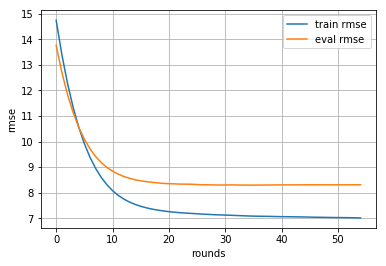

In [10]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

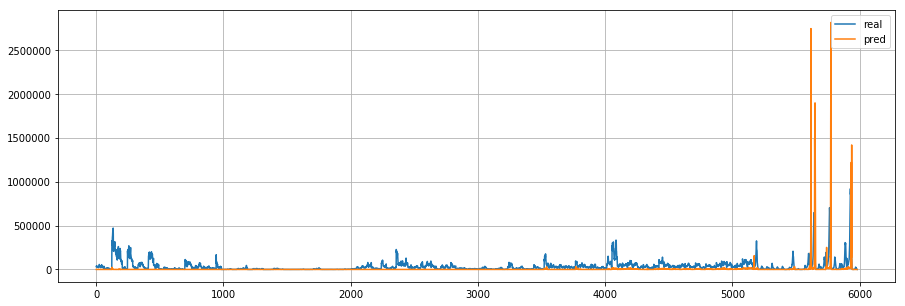

In [11]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Impressions'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

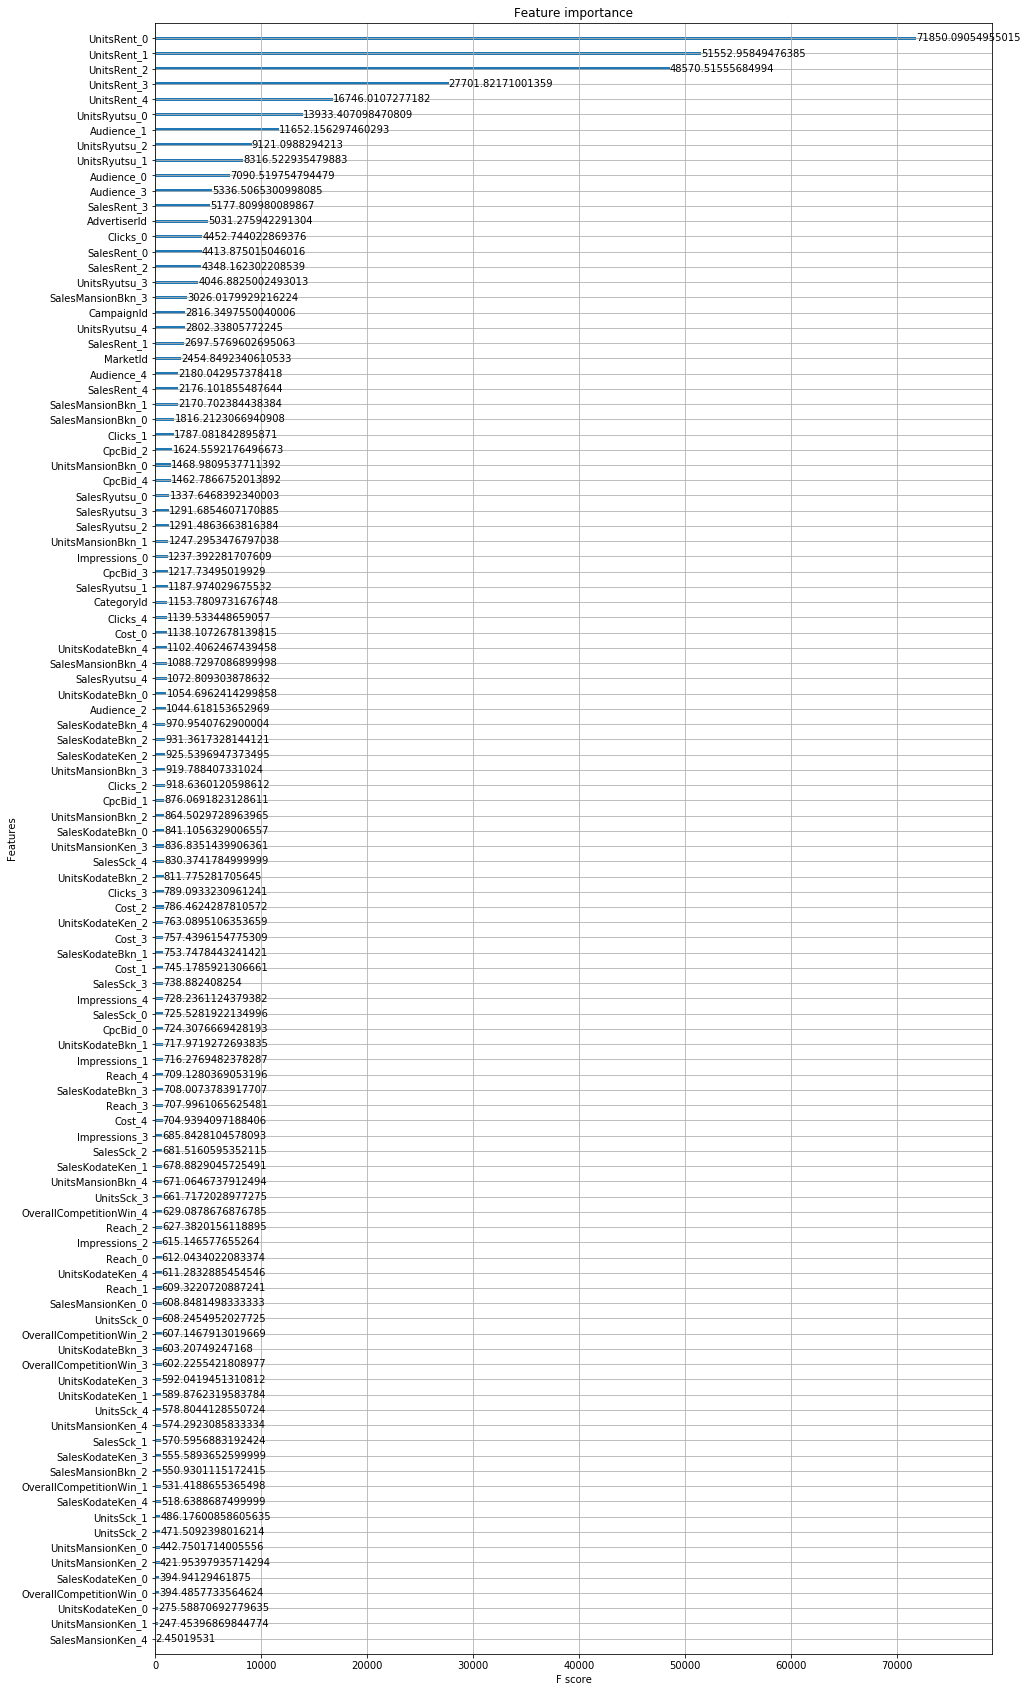

In [12]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [13]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['UnitsRent_0',
 'UnitsRent_1',
 'UnitsRent_2',
 'UnitsRent_3',
 'UnitsRent_4',
 'UnitsRyutsu_0',
 'Audience_1',
 'UnitsRyutsu_2',
 'UnitsRyutsu_1',
 'Audience_0',
 'Audience_3',
 'SalesRent_3',
 'AdvertiserId',
 'Clicks_0',
 'SalesRent_0',
 'SalesRent_2',
 'UnitsRyutsu_3',
 'SalesMansionBkn_3',
 'CampaignId',
 'UnitsRyutsu_4',
 'SalesRent_1',
 'MarketId',
 'Audience_4',
 'SalesRent_4',
 'SalesMansionBkn_1',
 'SalesMansionBkn_0',
 'Clicks_1',
 'CpcBid_2',
 'UnitsMansionBkn_0',
 'CpcBid_4',
 'SalesRyutsu_0',
 'SalesRyutsu_3',
 'SalesRyutsu_2',
 'UnitsMansionBkn_1',
 'Impressions_0',
 'CpcBid_3',
 'SalesRyutsu_1',
 'CategoryId',
 'Clicks_4',
 'Cost_0',
 'UnitsKodateBkn_4',
 'SalesMansionBkn_4',
 'SalesRyutsu_4',
 'UnitsKodateBkn_0',
 'Audience_2',
 'SalesKodateBkn_4',
 'SalesKodateBkn_2',
 'SalesKodateKen_2',
 'UnitsMansionBkn_3',
 'Clicks_2',
 'CpcBid_1',
 'UnitsMansionBkn_2',
 'SalesKodateBkn_0',
 'UnitsMansionKen_3',
 'SalesSck_4',
 'UnitsKodateBkn_2',
 'Clicks_3',
 'Cost_2',
 'UnitsK